In [8]:
import time
import re
import pylab as pl
import numpy as np
import pylab as pl

from datetime import datetime, timedelta

import subprocess

import os
import pandas as pd



from joblib import Parallel, delayed
import shutil


from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

In [9]:
# time.sleep(120)

In [10]:
def str2datetime(s):
    parts = s.split('.')
    dt = datetime.strptime(parts[0], "%Y-%m-%d %H:%M:%S.*")
    return dt.replace(microsecond=int(parts[1]))


def remove_outliers(x, outlierConstant = 1.5):
    a = np.array(x)
    upper_quartile = np.percentile(a, 75)
    lower_quartile = np.percentile(a, 25)
    IQR = (upper_quartile - lower_quartile) * outlierConstant
    quartileSet = (lower_quartile - IQR, upper_quartile + IQR)
    resultList = []
    removedList = []
    for y in a.tolist():
        if y >= quartileSet[0] and y <= quartileSet[1]:
            resultList.append(y)
        else:
            removedList.append(y)
    return (resultList, removedList)
def getThroughput(experiment):

    result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


    result = result.decode("utf-8") 

    lines = result.split('\n')

    commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
#     commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

    Times = []
    lats = []

    for line in lines:
        m = commit_pat.match(line)
        if m:
#             try:

                time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
                float((line.split(' ')[1]).split(':')[2])
                Times.append(time_item)        

                lats.append(float(m.group(2)))
                print(lats[-1])
#             except:
#                 continue


    begin_time = None
    values = []
    interval = 1
    cnt = 0
    Times.sort()
    for timestamp in Times:
        if begin_time is None:
            begin_time = timestamp
            next_begin_time = timestamp +interval

        while timestamp >= next_begin_time:
            begin_time = next_begin_time
            next_begin_time += interval
            values.append(cnt)
            cnt = 0
        cnt += 1
    values.append(cnt)
    
#     lats, _ = remove_outliers(lats)
#     print(len(values))


    return np.arange(len(values))*interval,np.array(values)/interval, lats

In [11]:
# p = subprocess.Popen(['../../hotstuff-keygen', ' --num', '--n', str(4)],
#                      stdout=subprocess.PIPE, stderr=open(os.devnull, 'w'))

In [12]:
# print([[t[4:] for t in l.decode('ascii').split()] for l in p.stdout])
# # [[t for t in l.decode('ascii').split()] for l in p.stdout.read()]

In [13]:
# os.system('echo 3108 | sudo -S sh job_mini.sh '+ 'test')


In [14]:
# regions= ['us-west-1', 'ap-south-1']
# regions= ['ap-south-1', 'eu-central-1', 'us-west-2']
# regions= ['ap-south-1', 'eu-central-1']
regions= ['ap-south-1']


instance_type = 't2.small'

In [15]:
# df

In [16]:

# # Node config for remote view change and leader/non leader failures

# %%file node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'ap-south-1', 0, 0, 'FKA.pem', -1, 0,
# 1, 'ap-south-1', 0, 0, 'FKA.pem', -1, 1,
# 2, 'ap-south-1', 0, 0, 'FKA.pem', -1, 2,
# 3, 'ap-south-1', 0, 0, 'FKA.pem', -1, 3,
# 4, 'ap-south-1', 0, 0, 'FKA.pem', -1, 4,
# 5, 'ap-south-1', 0, 0, 'FKA.pem', -1, 5,
# 6, 'ap-south-1', 0, 0, 'FKA.pem', -1, 6,
# 7, 'ap-south-1', 0, 0, 'FKA.pem', -1, 7,
# 8, 'ap-south-1', 0, 0, 'FKA.pem', -1, 8,
# 9, 'ap-south-1', 0, 0, 'FKA.pem', -1, 9,
# 10, 'ap-south-1', 0, 0, 'FKA.pem', -1, 10,
# 11, 'ap-south-1', 0, 0, 'FKA.pem', -1, 11,
# 12, 'ap-south-1', 0, 0, 'FKA.pem', -1, 12,
# 13, 'ap-south-1', 0, 0, 'FKA.pem', -1, 13,
# 14, 'ap-south-1', 0, 0, 'FKA.pem', -1, 14,
# 15, 'ap-south-1', 0, 0, 'FKA.pem', -1, 15,
# 16, 'ap-south-1', 0, 0, 'FKA.pem', -1, 16,
# 17, 'ap-south-1', 0, 0, 'FKA.pem', -1, 17,
# 18, 'ap-south-1', 0, 0, 'FKA.pem', -1, 18,
# 19, 'ap-south-1', 0, 0, 'FKA.pem', -1, 19,
# 20, 'ap-south-1', 1, -1, 'FKA.pem', 0, -1,
# 21, 'ap-south-1', 1, -1, 'FKA.pem', 1, -1,



In [17]:
# %%file node_info.csv
# node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
# 0, 'ap-south-1', 0, 0, 'FKA.pem', -1, 0,
# 1, 'ap-south-1', 0, 0, 'FKA.pem', -1, 1,
# 2, 'ap-south-1', 0, 0, 'FKA.pem', -1, 2,
# 3, 'ap-south-1', 0, 0, 'FKA.pem', -1, 3,
# 4, 'ap-south-1', 0, 0, 'FKA.pem', -1, 4,
# 5, 'ap-south-1', 0, 0, 'FKA.pem', -1, 5,
# 6, 'ap-south-1', 0, 0, 'FKA.pem', -1, 6,
# 7, 'ap-south-1', 0, 0, 'FKA.pem', -1, 7,
# 8, 'ap-south-1', 0, 1, 'FKA.pem', -1, 8,
# 9, 'ap-south-1', 0, 1, 'FKA.pem', -1, 9,
# 10, 'ap-south-1', 0, 1, 'FKA.pem', -1, 10,
# 11, 'ap-south-1', 0, 1, 'FKA.pem', -1, 11,
# 12, 'ap-south-1', 0, 1, 'FKA.pem', -1, 12,
# 13, 'ap-south-1', 0, 1, 'FKA.pem', -1, 13,
# 14, 'ap-south-1', 0, 1, 'FKA.pem', -1, 14,
# 15, 'ap-south-1', 0, 1, 'FKA.pem', -1, 15,
# 16, 'ap-south-1', 1, -1, 'FKA.pem', 0, -1,
# 17, 'ap-south-1', 1, -1, 'FKA.pem', 1, -1,
# 18, 'ap-south-1', 1, -1, 'FKA.pem', 2, -1,
# 19, 'ap-south-1', 1, -1, 'FKA.pem', 3, -1,
# 20, 'eu-central-1', 0, 2, 'FKE.pem', -1, 16,
# 21, 'eu-central-1', 0, 2, 'FKE.pem', -1, 17,
# 22, 'eu-central-1', 0, 2, 'FKE.pem', -1, 18,
# 23, 'eu-central-1', 0, 2, 'FKE.pem', -1, 19,
# 24, 'eu-central-1', 0, 2, 'FKE.pem', -1, 20,
# 25, 'eu-central-1', 0, 2, 'FKE.pem', -1, 21,
# 26, 'eu-central-1', 0, 2, 'FKE.pem', -1, 22,
# 27, 'eu-central-1', 0, 2, 'FKE.pem', -1, 23,
# 28, 'eu-central-1', 0, 3, 'FKE.pem', -1, 24,
# 29, 'eu-central-1', 0, 3, 'FKE.pem', -1, 25,
# 30, 'eu-central-1', 0, 3, 'FKE.pem', -1, 26,
# 31, 'eu-central-1', 0, 3, 'FKE.pem', -1, 27,
# 32, 'eu-central-1', 0, 3, 'FKE.pem', -1, 28,
# 33, 'eu-central-1', 0, 3, 'FKE.pem', -1, 29,
# 34, 'eu-central-1', 0, 3, 'FKE.pem', -1, 30,
# 35, 'eu-central-1', 0, 3, 'FKE.pem', -1, 31,
# 36, 'eu-central-1', 1, -1, 'FKE.pem', 4, -1,
# 37, 'eu-central-1', 1, -1, 'FKE.pem', 5, -1,
# 38, 'eu-central-1', 1, -1, 'FKE.pem', 6, -1,
# 39, 'eu-central-1', 1, -1, 'FKE.pem', 7, -1,
# 40, 'us-west-2', 0, 4, 'FKU2.pem', -1, 32,
# 41, 'us-west-2', 0, 4, 'FKU2.pem', -1, 33,
# 42, 'us-west-2', 0, 4, 'FKU2.pem', -1, 34,
# 43, 'us-west-2', 0, 4, 'FKU2.pem', -1, 35,
# 44, 'us-west-2', 0, 4, 'FKU2.pem', -1, 36,
# 45, 'us-west-2', 0, 4, 'FKU2.pem', -1, 37,
# 46, 'us-west-2', 0, 4, 'FKU2.pem', -1, 38,
# 47, 'us-west-2', 0, 4, 'FKU2.pem', -1, 39,
# 48, 'us-west-2', 0, 5, 'FKU2.pem', -1, 40,
# 49, 'us-west-2', 0, 5, 'FKU2.pem', -1, 41,
# 50, 'us-west-2', 0, 5, 'FKU2.pem', -1, 42,
# 51, 'us-west-2', 0, 5, 'FKU2.pem', -1, 43,
# 52, 'us-west-2', 0, 5, 'FKU2.pem', -1, 44,
# 53, 'us-west-2', 0, 5, 'FKU2.pem', -1, 45,
# 54, 'us-west-2', 0, 5, 'FKU2.pem', -1, 46,
# 55, 'us-west-2', 0, 5, 'FKU2.pem', -1, 47,
# 56, 'us-west-2', 1, -1, 'FKU2.pem', 8, -1,
# 57, 'us-west-2', 1, -1, 'FKU2.pem', 9, -1,
# 58, 'us-west-2', 1, -1, 'FKU2.pem', 10, -1,
# 59, 'us-west-2', 1, -1, 'FKU2.pem', 11, -1,

In [18]:
%%file node_info.csv
node_id,region,ServerOrClientregion,cluster_id,key_file,clientID,ServerID, PublicIp
0, 'ap-south-1', 0, 0, 'FKA.pem', -1, 0,
1, 'ap-south-1', 0, 0, 'FKA.pem', -1, 1,
2, 'ap-south-1', 0, 0, 'FKA.pem', -1, 2,
3, 'ap-south-1', 0, 0, 'FKA.pem', -1, 3,
4, 'ap-south-1', 0, 1, 'FKA.pem', -1, 4,
5, 'ap-south-1', 0, 1, 'FKA.pem', -1, 5,
6, 'ap-south-1', 0, 1, 'FKA.pem', -1, 6,
7, 'ap-south-1', 0, 1, 'FKA.pem', -1, 7,
8, 'ap-south-1', 0, 2, 'FKA.pem', -1, 8,
9, 'ap-south-1', 0, 2, 'FKA.pem', -1, 9,
10, 'ap-south-1', 0, 2, 'FKA.pem', -1, 10,
11, 'ap-south-1', 0, 2, 'FKA.pem', -1, 11,
12, 'ap-south-1', 0, 3, 'FKA.pem', -1, 12,
13, 'ap-south-1', 0, 3, 'FKA.pem', -1, 13,
14, 'ap-south-1', 0, 3, 'FKA.pem', -1, 14,
15, 'ap-south-1', 0, 3, 'FKA.pem', -1, 15,
16, 'ap-south-1', 0, 4, 'FKA.pem', -1, 16,
17, 'ap-south-1', 0, 4, 'FKA.pem', -1, 17,
18, 'ap-south-1', 0, 4, 'FKA.pem', -1, 18,
19, 'ap-south-1', 0, 4, 'FKA.pem', -1, 19,
20, 'ap-south-1', 0, 5,'FKA.pem', -1, 20,
21, 'ap-south-1', 0, 5,'FKA.pem', -1, 21,
22, 'ap-south-1', 0, 5,'FKA.pem', -1, 22,
23, 'ap-south-1', 0, 5,'FKA.pem', -1, 23,
24, 'ap-south-1', 0, 6,'FKA.pem', -1, 24,
25, 'ap-south-1', 0, 6,'FKA.pem', -1, 25,
26, 'ap-south-1', 0, 6,'FKA.pem', -1, 26,
27, 'ap-south-1', 0, 6,'FKA.pem', -1, 27,
28, 'ap-south-1', 0, 7,'FKA.pem', -1, 28,
29, 'ap-south-1', 0, 7,'FKA.pem', -1, 29,
30, 'ap-south-1', 0, 7,'FKA.pem', -1, 30,
31, 'ap-south-1', 0, 7,'FKA.pem', -1, 31,
32, 'ap-south-1', 0, 8,'FKA.pem', -1, 32,
33, 'ap-south-1', 0, 8,'FKA.pem', -1, 33,
34, 'ap-south-1', 0, 8,'FKA.pem', -1, 34,
35, 'ap-south-1', 0, 8,'FKA.pem', -1, 35,
36, 'ap-south-1', 0, 9,'FKA.pem', -1, 36,
37, 'ap-south-1', 0, 9,'FKA.pem', -1, 37,
38, 'ap-south-1', 0, 9,'FKA.pem', -1, 38,
39, 'ap-south-1', 0, 9,'FKA.pem', -1, 39,
40, 'ap-south-1', 0, 10,'FKA.pem', -1, 40,
41, 'ap-south-1', 0, 10,'FKA.pem', -1, 41,
42, 'ap-south-1', 0, 10, 'FKA.pem', -1, 42,
43, 'ap-south-1', 0, 10, 'FKA.pem', -1, 43,
44, 'ap-south-1', 0, 11, 'FKA.pem', -1, 44,
45, 'ap-south-1', 0, 11, 'FKA.pem', -1, 45,
46, 'ap-south-1', 0, 11, 'FKA.pem', -1, 46,
47, 'ap-south-1', 0, 11, 'FKA.pem', -1, 47,
48, 'ap-south-1', 1, -1, 'FKA.pem', 0, -1,
49, 'ap-south-1', 1, -1, 'FKA.pem', 1, -1,
50, 'ap-south-1', 1, -1, 'FKA.pem', 2, -1,
51, 'ap-south-1', 1, -1, 'FKA.pem', 3, -1,
52, 'ap-south-1', 1, -1, 'FKA.pem', 4, -1,
53, 'ap-south-1', 1, -1, 'FKA.pem', 5, -1,
54, 'ap-south-1', 1, -1, 'FKA.pem', 6, -1,
55, 'ap-south-1', 1, -1, 'FKA.pem', 7, -1,
56, 'ap-south-1', 1, -1, 'FKA.pem', 8, -1,
57, 'ap-south-1', 1, -1, 'FKA.pem', 9, -1,
58, 'ap-south-1', 1, -1, 'FKA.pem', 10, -1,
59, 'ap-south-1', 1, -1, 'FKA.pem', 11, -1,


Overwriting node_info.csv


In [19]:
df =pd.read_csv('node_info.csv')

node_info_dict = df.to_dict()

node_info_dict

{'node_id': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59},
 'region': {0: " 'ap-south-1'",
  1: " 'ap-south-1'",
  2: " 'ap-south-1'",
  3: " 'ap-south-1'",
  4: " 'ap-south-1'",
  5: " 'ap-south-1'",
  6: " 'ap-south-1'",
  7: " 'ap-south-1'",
  8: " 'ap-south-1'",
  9: " 'ap-south-1'",
  10: " 'ap-south-1'",
  11: " 'ap-south-1'",
  12: " 'ap-south-1'",
  13: " 'ap-south-1'",
  14: " 'ap-south-1'",
  15: " 'ap-south-1'",
  16: " 'ap-south-1'",
  17: " 'ap-south

In [110]:

# instance_type2 = 'c4.4xlarge'
# redirect2 = '>>'

for index, region  in enumerate(regions):
    
    print(index, region)
    redirect = '>>'
    if index==0:
        redirect = '>'
        
    os.system("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
              instance_type+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
              redirect+" all_internal_ips")
    
    
    print("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
              instance_type+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
              redirect+" all_internal_ips")


    os.system("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
          instance_type+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
          redirect+" all_external_ips")
    
    
    print("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
          instance_type+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
          redirect+" all_external_ips")
    
    

#     os.system("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
#           instance_type2+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
#           redirect2+" all_internal_ips")



#     os.system("aws --region "+region+" ec2 describe-instances  --filter Name=instance-type,Values="+\
#           instance_type2+" --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text "+\
#           redirect2+" all_external_ips")
    
    
    
    
    

0 ap-south-1
aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_internal_ips
aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --filter Name=instance-state-name,Values=running --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips


In [111]:
!cat all_internal_ips
! echo " " 
# !cat all_external_ips

65.2.151.32
13.233.85.179
13.232.238.58
13.126.30.239
13.232.69.67
15.207.86.212
3.111.168.212
13.235.244.71
35.154.26.197
13.235.99.217
52.66.198.39
3.111.144.92
43.205.145.219
65.2.188.167
13.233.164.153
65.1.84.237
13.233.245.186
65.2.30.129
3.111.215.70
13.233.232.186
13.232.39.192
65.2.146.139
13.235.99.87
65.2.167.146
13.232.118.32
65.2.168.125
35.154.11.188
3.110.147.152
15.207.87.236
13.232.237.18
13.126.18.229
43.204.30.204
65.0.103.78
65.1.109.198
13.233.20.113
43.205.112.213
65.2.131.13
65.1.84.213
35.154.4.239
13.233.57.99
13.232.56.243
3.109.152.163
13.232.250.19
3.108.193.246
13.234.113.192
43.205.116.70
15.207.87.201
43.205.145.176
3.111.218.234
43.205.115.215
43.204.19.35
13.232.193.119
13.233.250.212
13.127.221.56
3.110.182.24
65.2.140.170
3.108.66.103
43.204.37.183
15.206.66.201
13.126.221.201
 


In [112]:
f = open('all_external_ips', "r")
data1 = [line.strip() for line in f.readlines()]

data1 = [x for x in data1 if x!='None']

In [113]:
f = open('all_internal_ips', "r")
data2 = [line.strip() for line in f.readlines()]

data2 = [x for x in data2 if x!='None']

In [114]:
data2, len(data2)

(['65.2.151.32',
  '13.233.85.179',
  '13.232.238.58',
  '13.126.30.239',
  '13.232.69.67',
  '15.207.86.212',
  '3.111.168.212',
  '13.235.244.71',
  '35.154.26.197',
  '13.235.99.217',
  '52.66.198.39',
  '3.111.144.92',
  '43.205.145.219',
  '65.2.188.167',
  '13.233.164.153',
  '65.1.84.237',
  '13.233.245.186',
  '65.2.30.129',
  '3.111.215.70',
  '13.233.232.186',
  '13.232.39.192',
  '65.2.146.139',
  '13.235.99.87',
  '65.2.167.146',
  '13.232.118.32',
  '65.2.168.125',
  '35.154.11.188',
  '3.110.147.152',
  '15.207.87.236',
  '13.232.237.18',
  '13.126.18.229',
  '43.204.30.204',
  '65.0.103.78',
  '65.1.109.198',
  '13.233.20.113',
  '43.205.112.213',
  '65.2.131.13',
  '65.1.84.213',
  '35.154.4.239',
  '13.233.57.99',
  '13.232.56.243',
  '3.109.152.163',
  '13.232.250.19',
  '3.108.193.246',
  '13.234.113.192',
  '43.205.116.70',
  '15.207.87.201',
  '43.205.145.176',
  '3.111.218.234',
  '43.205.115.215',
  '43.204.19.35',
  '13.232.193.119',
  '13.233.250.212',
  '13.12

In [115]:
data = []

In [116]:
# for i in range(len(data1)):
#     if data1[i]!='None':
# #         data.append(data1[i] + '    ' + data2[i])
#         data.append('127.0.0.1'+ '    ' + '127.0.0.1')
    

skip_instances = 0
    
for i in range(skip_instances, len(data1)):
    if data1[i]!='None':
        data.append(data1[i] + '    ' + data2[i])
#         data.append('127.0.0.1'+ '    ' + '127.0.0.1')

In [117]:
data, len(data)

(['65.2.151.32    65.2.151.32',
  '13.233.85.179    13.233.85.179',
  '13.232.238.58    13.232.238.58',
  '13.126.30.239    13.126.30.239',
  '13.232.69.67    13.232.69.67',
  '15.207.86.212    15.207.86.212',
  '3.111.168.212    3.111.168.212',
  '13.235.244.71    13.235.244.71',
  '35.154.26.197    35.154.26.197',
  '13.235.99.217    13.235.99.217',
  '52.66.198.39    52.66.198.39',
  '3.111.144.92    3.111.144.92',
  '43.205.145.219    43.205.145.219',
  '65.2.188.167    65.2.188.167',
  '13.233.164.153    13.233.164.153',
  '65.1.84.237    65.1.84.237',
  '13.233.245.186    13.233.245.186',
  '65.2.30.129    65.2.30.129',
  '3.111.215.70    3.111.215.70',
  '13.233.232.186    13.233.232.186',
  '13.232.39.192    13.232.39.192',
  '65.2.146.139    65.2.146.139',
  '13.235.99.87    13.235.99.87',
  '65.2.167.146    65.2.167.146',
  '13.232.118.32    13.232.118.32',
  '65.2.168.125    65.2.168.125',
  '35.154.11.188    35.154.11.188',
  '3.110.147.152    3.110.147.152',
  '15.207.87.2

In [118]:
for index, item in enumerate(data1):
    if 'publicIP' not in node_info_dict.keys():
        node_info_dict['publicIP'] = {}

        
    node_info_dict['publicIP'][index] = item 
    
    
for index, item in enumerate(data2):
    if 'privateIP' not in node_info_dict.keys():
        node_info_dict['privateIP'] = {}
        
    node_info_dict['privateIP'][index] = item 
    
    
    
for index, item in enumerate(data):
    if 'publicAndprivateIP' not in node_info_dict.keys():
        node_info_dict['publicAndprivateIP'] = {}
        
    node_info_dict['publicAndprivateIP'][index] = item 

In [119]:
node_info_dict

{'node_id': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59},
 'region': {0: " 'ap-south-1'",
  1: " 'ap-south-1'",
  2: " 'ap-south-1'",
  3: " 'ap-south-1'",
  4: " 'ap-south-1'",
  5: " 'ap-south-1'",
  6: " 'ap-south-1'",
  7: " 'ap-south-1'",
  8: " 'ap-south-1'",
  9: " 'ap-south-1'",
  10: " 'ap-south-1'",
  11: " 'ap-south-1'",
  12: " 'ap-south-1'",
  13: " 'ap-south-1'",
  14: " 'ap-south-1'",
  15: " 'ap-south-1'",
  16: " 'ap-south-1'",
  17: " 'ap-south

In [120]:
for item in node_info_dict['publicAndprivateIP']:
    print(node_info_dict['publicAndprivateIP'][item])

65.2.151.32    65.2.151.32
13.233.85.179    13.233.85.179
13.232.238.58    13.232.238.58
13.126.30.239    13.126.30.239
13.232.69.67    13.232.69.67
15.207.86.212    15.207.86.212
3.111.168.212    3.111.168.212
13.235.244.71    13.235.244.71
35.154.26.197    35.154.26.197
13.235.99.217    13.235.99.217
52.66.198.39    52.66.198.39
3.111.144.92    3.111.144.92
43.205.145.219    43.205.145.219
65.2.188.167    65.2.188.167
13.233.164.153    13.233.164.153
65.1.84.237    65.1.84.237
13.233.245.186    13.233.245.186
65.2.30.129    65.2.30.129
3.111.215.70    3.111.215.70
13.233.232.186    13.233.232.186
13.232.39.192    13.232.39.192
65.2.146.139    65.2.146.139
13.235.99.87    13.235.99.87
65.2.167.146    65.2.167.146
13.232.118.32    13.232.118.32
65.2.168.125    65.2.168.125
35.154.11.188    35.154.11.188
3.110.147.152    3.110.147.152
15.207.87.236    15.207.87.236
13.232.237.18    13.232.237.18
13.126.18.229    13.126.18.229
43.204.30.204    43.204.30.204
65.0.103.78    65.0.103.78
65.

In [121]:
with open('replicas.txt', 'w') as f:
    
    for item in node_info_dict['publicAndprivateIP']:
        
        if (node_info_dict['ServerOrClientregion'][item] ==0):
            f.write("%s\n" % node_info_dict['publicAndprivateIP'][item])
    

In [122]:
node_info_dict['ServerOrClientregion']

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 1,
 49: 1,
 50: 1,
 51: 1,
 52: 1,
 53: 1,
 54: 1,
 55: 1,
 56: 1,
 57: 1,
 58: 1,
 59: 1}

In [123]:
! cat replicas.txt

65.2.151.32    65.2.151.32
13.233.85.179    13.233.85.179
13.232.238.58    13.232.238.58
13.126.30.239    13.126.30.239
13.232.69.67    13.232.69.67
15.207.86.212    15.207.86.212
3.111.168.212    3.111.168.212
13.235.244.71    13.235.244.71
35.154.26.197    35.154.26.197
13.235.99.217    13.235.99.217
52.66.198.39    52.66.198.39
3.111.144.92    3.111.144.92
43.205.145.219    43.205.145.219
65.2.188.167    65.2.188.167
13.233.164.153    13.233.164.153
65.1.84.237    65.1.84.237
13.233.245.186    13.233.245.186
65.2.30.129    65.2.30.129
3.111.215.70    3.111.215.70
13.233.232.186    13.233.232.186
13.232.39.192    13.232.39.192
65.2.146.139    65.2.146.139
13.235.99.87    13.235.99.87
65.2.167.146    65.2.167.146
13.232.118.32    13.232.118.32
65.2.168.125    65.2.168.125
35.154.11.188    35.154.11.188
3.110.147.152    3.110.147.152
15.207.87.236    15.207.87.236
13.232.237.18    13.232.237.18
13.126.18.229    13.126.18.229
43.204.30.204    43.204.30.204
65.0.103.78    65.0.103.78
65.

In [124]:
with open('clients.txt', 'w') as f:
    
    for item in node_info_dict['publicIP']:
        
        if (node_info_dict['ServerOrClientregion'][item] ==1):
            f.write("%s\n" % node_info_dict['publicIP'][item])

In [125]:
os.system('cat clients.txt')

3.111.218.234
43.205.115.215
43.204.19.35
13.232.193.119
13.233.250.212
13.127.221.56
3.110.182.24
65.2.140.170
3.108.66.103
43.204.37.183
15.206.66.201
13.126.221.201


0

In [126]:
node_info_dict

{'node_id': {0: 0,
  1: 1,
  2: 2,
  3: 3,
  4: 4,
  5: 5,
  6: 6,
  7: 7,
  8: 8,
  9: 9,
  10: 10,
  11: 11,
  12: 12,
  13: 13,
  14: 14,
  15: 15,
  16: 16,
  17: 17,
  18: 18,
  19: 19,
  20: 20,
  21: 21,
  22: 22,
  23: 23,
  24: 24,
  25: 25,
  26: 26,
  27: 27,
  28: 28,
  29: 29,
  30: 30,
  31: 31,
  32: 32,
  33: 33,
  34: 34,
  35: 35,
  36: 36,
  37: 37,
  38: 38,
  39: 39,
  40: 40,
  41: 41,
  42: 42,
  43: 43,
  44: 44,
  45: 45,
  46: 46,
  47: 47,
  48: 48,
  49: 49,
  50: 50,
  51: 51,
  52: 52,
  53: 53,
  54: 54,
  55: 55,
  56: 56,
  57: 57,
  58: 58,
  59: 59},
 'region': {0: " 'ap-south-1'",
  1: " 'ap-south-1'",
  2: " 'ap-south-1'",
  3: " 'ap-south-1'",
  4: " 'ap-south-1'",
  5: " 'ap-south-1'",
  6: " 'ap-south-1'",
  7: " 'ap-south-1'",
  8: " 'ap-south-1'",
  9: " 'ap-south-1'",
  10: " 'ap-south-1'",
  11: " 'ap-south-1'",
  12: " 'ap-south-1'",
  13: " 'ap-south-1'",
  14: " 'ap-south-1'",
  15: " 'ap-south-1'",
  16: " 'ap-south-1'",
  17: " 'ap-south

In [127]:
# def run_server_node_remote(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps[:-3]):
#     if ip!='None' and( ip in nodeIps):
        
        
#         current = (ip.split('.'))
#         command = './examples/hotstuff-app --conf hotstuff.gen-sec'+str(nodeIps.index(ip))+'.conf '
        
#         print(i,command)
        
        
        
# for i in range(len(lines)):
#     print(i)
#     run_server_node_remote(i)
    
    

        
# def run_client_node_remote(i):
#     ip = lines[i]
#     if ip!='None' and( ip in clientIps):
        
#         current = (ip.split('.'))
#         command = './examples/hotstuff-client --idx 0 --iter -1 --max-async 5 >../nohup.out 2>&1 &"'
        
#         print(command)

# for i in range(len(lines)):
#     print(i)
#     run_client_node_remote(i)


In [128]:
# # # os.system('echo 3108 | sudo -S ls')/FinalKeys.pem

# # experiment = 'exp_f1'

# # os.system('echo 3108 | sudo -S sh job_mini1.sh '+experiment)

# # os.system('./run_cli.sh new '+experiment+'_cli;')
# # os.system('sleep 30;')
# # kill_nodes(3)

# # # run_server_node(3)

# # os.system('sleep 30;')

# # os.system('./run_cli.sh stop '+experiment+'_cli;')
# # os.system('./run.sh stop '+experiment+';')
# # os.system('./run_cli.sh fetch '+experiment+'_cli;')
# # os.system('cat '+experiment+'_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')



# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps[:-3]):
#     if ip!='None':

#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd /home/ubuntu/testbed/'+experiment+'/0/conf/; sudo nohup ../../../../libhotstuff/examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'+experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'

#         print(command)
#         os.system(command)
        
        
# def run_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps[:-3]):
#     if ip!='None' and ip in lines[:nnodes]:

#         current = (ip.split('.'))
#         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf > ../temp/nohup_'+str(i)+'.out 2>&1 &'

#         print(command)
#         os.system(command)
        
        
# def run_client(i):
#     ip = lines[i]
#     client_no = i - nnodes
#     if ip!='None' and( ip in lines[nnodes:]):
        
#         current = (ip.split('.'))
#         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'.out 2>&1 &'
        
#         print(command)
#         os.system(command)
        
        
        
# def run_client2(i):
#     ip = lines[i]
#     client_no = i - nnodes
#     if ip!='None' and( ip in lines[nnodes:]):
        
#         current = (ip.split('.'))
#         command = 'echo 1234 | sudo -S nohup ../../examples/hotstuff-client --idx '+str(client_no)+' --iter -1 --max-async 4 > ../temp/nohup_client_'+str(i)+'_2.out 2>&1 &'
        
#         print(command)
#         os.system(command)
        
        
        
# # def run_join_node(i):
# #     ip = lines[i]
# #     if ip!='None':
        
# #         current = (ip.split('.'))
# #         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf '+'/home/ubuntu/testbed/'
# #         +experiment+'/0/conf/'+'hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
# #         print(command)
# #         os.system(command)
        

        

# # def kill_nodes(i):
# #     ip = lines[i]
    
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
# #               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'
        
# #         output = subprocess.getoutput(command)
# #         print(output)

        



# # # run_server_node(3)

# # # current



# # os.system('cat exp_4c5n_cli/remote/*/log/stderr | python3 ../thr_hist.py --plot')

In [129]:
def setup_remote(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "sudo apt -y update;sudo apt -y install build-essential; sudo apt -y install autoconf libtool libssl-dev libuv1-dev cmake pkg-config cmake-data make; sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'
        print(command)
        
        output = os.system(command)
        print(output)
        
        
def setup_remote2(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T " cd hotstuffO; git pull;"'
#         print(command)
        
        output = os.system(command)
        print(output)
        
        
def git_pull_remote(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo git pull;"'

        
        output = subprocess.getoutput(command)
        print(output)


        
        
def run_join_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and( ip == nodeIps[-1]):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)
        
        
        
def run_join_node1_remote(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and( ip == nodeIps[-1]):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)
        
def run_join_node2_remote(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and( ip == nodeIps[-2]):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)
        
def run_join_node3_remote(i):
    ip = node_info_dict['publicIP'][i] 
    if ip!='None' and( ip == nodeIps[-3]):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(i)+'.conf >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)

        

def kill_nodes_remote(i):
    ip = node_info_dict['publicIP'][i] 
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo killall hotstuff-app; sudo killall hotstuff-client;"'
        
        output = subprocess.getoutput(command)
        print(output)

        

def clean_nodes_remote(i):
    ip = node_info_dict['publicIP'][i] 
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "sudo rm -f nohup.out;"'
        
        print(command)
        os.system(command)

In [130]:
experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('echo 3108 | sudo -S sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

[sudo] password for tejas: CMake Warning:
  No source or binary directory provided.  Both will be assumed to be the
  same as the current working directory, but note that this warning will
  become a fatal error in future CMake releases.




Name of TestRun: test
-- Found OpenSSL: /usr/lib/x86_64-linux-gnu/libcrypto.so (found suitable version "3.0.2", minimum required is "1.1.0")  
-- Found OpenSSL: /usr/lib/x86_64-linux-gnu/libcrypto.so (found version "3.0.2")  
-- Could NOT find Doxygen (missing: DOXYGEN_EXECUTABLE) 
-- Configuring done
-- Generating done
-- Build files have been written to: /home/tejas/work/hotstuffO
[ 21%] Built target libsecp256k1
Consolidate compiler generated dependencies of target hotstuff
Consolidate compiler generated dependencies of target salticidae
[ 62%] Built target salticidae
[ 62%] Built target hotstuff
[ 64%] Built target salticidae_shared
[ 67%] Built target salticidae_static
[ 70%] Built target hotstuff_static
[ 72%] Built target hotstuff_shared
Consolidate compiler generated dependencies of target hotstuff-app
Consolidate compiler generated dependencies of target hotstuff-keygen
Consolidate compiler generated dependencies of target hotstuff-tls-keygen
Consolidate compiler generated dep

0

In [131]:
import os
os.system('cd ../../; git add .; git commit -m "Testing"; git push -f')

[main d71fa2a] Testing
 106 files changed, 7769 insertions(+), 3425 deletions(-)
 rewrite hotstuff.gen-sec0.conf (91%)
 rewrite hotstuff.gen-sec1.conf (91%)
 rewrite hotstuff.gen-sec10.conf (91%)
 rewrite hotstuff.gen-sec11.conf (91%)
 rewrite hotstuff.gen-sec12.conf (91%)
 rewrite hotstuff.gen-sec13.conf (91%)
 rewrite hotstuff.gen-sec14.conf (91%)
 rewrite hotstuff.gen-sec15.conf (91%)
 rewrite hotstuff.gen-sec16.conf (91%)
 rewrite hotstuff.gen-sec17.conf (91%)
 rewrite hotstuff.gen-sec18.conf (91%)
 rewrite hotstuff.gen-sec19.conf (91%)
 rewrite hotstuff.gen-sec2.conf (91%)
 rewrite hotstuff.gen-sec20.conf (91%)
 rewrite hotstuff.gen-sec21.conf (91%)
 rewrite hotstuff.gen-sec22.conf (91%)
 rewrite hotstuff.gen-sec23.conf (91%)
 rewrite hotstuff.gen-sec24.conf (91%)
 rewrite hotstuff.gen-sec25.conf (91%)
 rewrite hotstuff.gen-sec26.conf (91%)
 rewrite hotstuff.gen-sec27.conf (91%)
 rewrite hotstuff.gen-sec28.conf (91%)
 rewrite hotstuff.gen-sec29.conf (91%)
 rewrite hotstuff.gen-sec

To github.com:tmane002/hotstuffO.git
   c4c76c9..d71fa2a  main -> main


0

In [132]:

# # def setup_remote3(i):

# #     ip = node_info_dict['publicIP'][i] 
# #     if ip!='None':
# #         current = (ip.split('.'))
# #         command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
# #                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"'
# #         print(command)
        
# #         output = os.system(command)
# #         print(output)


# results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote)(i)\
#                                                                        for i in [9])#node_info_dict['node_id'])


# print(results)  

In [133]:
    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  


    
# for i in node_info_dict['publicIP']:
#     print(i)
#     setup_remote2(i)

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-13-232-238-58.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-3-111-168-212.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.












Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-

Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.c

Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/un

Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [868 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-

Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [212 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [868 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.6 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [668 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [212 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.6 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [668 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:16 h

Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.3 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 c-n-f Metadata [576 B]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-

Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-

Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [209 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [21.5 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [140 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9768 B]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.8 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f M

Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 

Fetched 26.5 MB in 5s (5273 kB/s)
Reading package lists...
Building dependency tree...

Building dependency tree...
Reading state information...
105 packages can be upgraded. Run 'apt list --upgradable' to see them.
Fetched 26.5 MB in 5s (5234 kB/s)
Reading package lists...Building dependency tree...Fetched 26.5 MB in 5s (5099 kB/s)
Reading package lists...
Reading state information...
Reading package lists...
105 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...
Reading package lists...Building dependency tree...
Building dependency tree...
Reading state information...

Reading state information...
105 packages can be upgraded. Run 'apt list --upgradable' to see them.

Building dependency tree...
Reading state information...

Reading state information...
Reading package lists...
105 packages can be upgraded. Run 'apt list --upgradable' to see them.
Building dependency tree...The following additional packages will be installed:
  bzip2 cpp c

The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
The following packages will be upgraded:
  gcc-12-base libgcc-s1 libstdc++6
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl lib

Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Fetched 26.5 MB in 5s (5144 kB/s)
Reading package lists...Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.4.0-1ubuntu1~22.04 [20.2 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl2

105 packages can be upgraded. Run 'apt list --upgradable' to see them.
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-base amd64 12.3.0-1ubuntu1~22.04 [20.1 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++6 amd64 12.3.0-1ubuntu1~22.04 [699 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.3.0-1ubuntu1~22.04 [1069 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-s1 amd64 12.3.0-1ubuntu1~22.04 [53.9 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [1307 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/ma


Reading state information...
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
105 packages can be upgraded. Run 'apt list --upgradable' to see them.
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.3.0-1ubuntu1~22.04 [48.3 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.4.0-1ubuntu1~22.04 [11.4 MB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.3.0-1ubuntu1~22.04 [126 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.3.0-1ubuntu1~22.04 [30.2 kB]
Get:19 http://ap-south-1.ec2.archive.ubun

Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:35 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 






105 packages can be upgraded. Run 'apt list --upgradable' to see them.

Reading state information...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.3.0-1ubuntu1~22.04 [48.3 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.3.0-1ubuntu1~22.04 [126 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.3.0-1ubuntu1~22.04 [30.2 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.3.0-1ubuntu1~22.04 [10.4 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libasan6 amd64 11.4.0-1ubuntu1~22.04 [2282 kB]
105 packages can be upgraded. Run 'apt list --upgradable' to see them.
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fa



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++6 amd64 12.3.0-1ubuntu1~22.04 [699 kB]

(Reading database ... 64295 files and directories currently installed.)
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-s1 amd64 12.3.0-1ubuntu1~22.04 [53.9 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [1307 kB]
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...

Building dependency tree...Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.3.0-1ubuntu1~22.04 [48.3 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.3.0-1ubuntu1~22.04 [126 kB]

Reading state information...
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.3.0-1ubuntu1~22.04 [30.2 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.3.0-1ubuntu1~22.04 [10.4 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-base amd64 12.3.0-1ubuntu1~22.04 [20.1 kB]
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++6 amd64 12.3.0-1ubuntu1~22.04 [699 kB]
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-s1 amd64 12.3.0-1ubuntu1~22.04 [53.9 kB]
3 upgraded, 52 newly inst

Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Get:46 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Get:48 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Get:49 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libwebp7 amd64 1.2.2-2ubuntu0.22.04.1 [206 kB]
Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Get:51 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libxpm4 amd64 1:3.5

The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
  liblsan0 libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libstdc++6
  libtiff5 libtirpc-dev libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ubuntu1~22.04 [2260 kB]
  lto-disabled-list make manpages-dev rpcsvc-proto
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
(Reading database ... 64295 files and directories currently installed.)
Prepar



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Building dependency tree...Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
(Reading database ... 
Reading state information...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Preparing to unpack .

Selecting previously unselected package gcc-11-base:amd64.
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.4.0-1ubuntu1~22.04 [11.4 MB]
Selecting previously unselected package libtirpc-dev:amd64.
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
The following packages will be upgraded:
  gcc-12-base libgcc-s1 libstdc++6
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package libcrypt-dev:amd64.
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ..

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.4.0-1ubuntu1~22.04 [10.0 MB]
(Reading database ... 65%
Building dependency tree...Selecting previously unselected package libnsl-dev:amd64.
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]

Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
Selecting previously unselected package libc6-dev:amd64.
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:16 http://ap-south-1.ec2.archive.u

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.4.0-1ubuntu1~22.04 [20.2 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Fetched 64.5 MB in 1s (55.8 MB/s)
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.4.0-1ubuntu1~22.04 [10.0 MB]
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unp

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libcrypt-dev:amd64.
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libitm1:amd64.
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.3.0-1ubuntu1~22.04 [976 kB]
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Unpacking libitm1:amd64 

Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Selecting previously unselected package libitm1:amd64.
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libgcc-11-dev:amd64.
Unpacking libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../21-libgcc-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.Unpacking liblsan0:am

Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libnsl-dev:amd64.
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.3.0-1ubuntu1~22.04 [48.3 kB]
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.3.0-1ubuntu1~22.04 [126 kB]
(Reading database ... 64295 files and directories currently installed.)
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.3.0-1ubuntu1~22.04 [30.2 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.3.0-1ubuntu1~22.04 [10.4 kB]
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Get:20 http://

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Fetched 64.5 MB in 2s (40.3 MB/s)
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Selecting previously unselected package libc6-dev:amd64.
Get:46 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Selecting previously unselected package g++-11.
Preparing to unpack .../06-libc6

Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...

Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libgomp1:amd64.
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libisl23:amd64.
Selecting previously unselected package libmpc3:amd64.
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libquadmath0:amd64.
Preparing to unpack .../libstdc++6_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Unpacking make (4.3-4.1build1) ...
Selecting previously unselected package libasan6:amd64.
Selecting previously unselected package g++-11.
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package fakeroot.
Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Selecting previously unselected package libdpkg-perl.
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Selecting previously unselected package fonts-dejavu-core.
Selecting previously unselected package build-essential.
Preparing to unpack .../

Unpacking libalgorithm-merge-perl (0.08-3) ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libatomic1:amd64.
Selecting previously unselected package gcc-11.
Preparing to unpack .../15-libatomic1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package make.
(Reading database ... 64295 files and directories currently installed.)Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...

Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64

Selecting previously unselected package build-essential.Selecting previously unselected package libjbig0:amd64.

Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Unpacking build-essential (12.9ubuntu3) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...Selecting previously unselected package libalgorithm-merge-perl.

Selecting previously unselected package dpkg-dev.
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Unpac

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package manpages-dev.
Unpacking gcc (4:11.2.0-1ubuntu1) ...Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...

Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libgd3:amd64.
Selecting previously unselected package libfakeroot:amd64.
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Unpacking libfakeroot:amd64 

Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Selecting previously unselected package libjbig0:amd64.
Selecting previously unselected package libjpeg-turbo8:amd64.
Setting up bzip2 (1.0.8-5build1) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package libisl23:amd64.
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Reading package lists...Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously un

Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package fakeroot.
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...Setting up fonts-dejavu-core (2.37-2build1) ...

Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Setting up liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libgd3:amd64.
Setting up linux-li

Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libjpeg8:amd64.
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package libalgorithm-merge-perl.
Selecting previously unselected package make.
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Preparing to

Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Selecting previously unselected package libwebp7:amd64.
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Selecting previously unselected package fontconfig-config.
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...

Reading state information...Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package dpkg-dev.
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...

Preparing to unpack .../33-libfakeroot_

Selecting previously unselected package libatomic1:amd64.
Unpacking libalgorithm-diff-perl (1.201-1) ...
Unpacking lto-disabled-list (24) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package fonts-dejavu-core.
Selecting previously unselected package libgcc-11-dev:amd64.
Preparing to unpack .../15-libatomic1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Selecting previously unselected package libdeflate0:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Preparing to unpack .../21-libgcc-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Selecting 

Selecting previously unselected package libgd3:amd64.
Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up bzip2 (1.0.8-5build1) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package gcc-11.
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up make (4.3-4.1build1) ...
Selecting previously unselected package libdeflate0:amd64.
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Selecting previously unselected package libc-devtools.
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Set


Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
Selecting previously unselected package libdeflate0:amd64.
 systemctl restart packagekit.service
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Unpacking libdeflate0:amd64 (1.10-2) ...
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up lto-disabled-list (24) ...
Selecting previously unselected package libjbig0:amd64.
Selecting previously unselected package gcc-11-base:amd64.
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Unpacking libjbig0:amd64 (2.

Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.

Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up bzip2 (1.0.8-5build1) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Setting up make (4.3-4.1build1) ...
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package cpp.
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...


Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libasan6 amd64 11.4.0-1ubuntu1~22.04 [2282 kB]
Reading package lists...Setting up libisl23:amd64 (0.24-2build1) ...

Building dependency tree...Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...

Running kernel seems to be up-to-date.

Services to be restarted:
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
 systemctl restart multipathd.service
Selecting previously unselected package libgomp1:amd64.
 systemctl restart packagekit.service
Setting up liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...

Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.3.0-1ubuntu1~22.04 [976 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjsoncpp25 amd64 1.9.5-3 [80.0 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 librhash0 amd64 1.4.2-1ubuntu1 [125 kB]

Running kernel seems to be up-to-date.

Services to be restarted:
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fro

The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data dh-elpa-helper
  emacsen-common libjsoncpp25 libltdl-dev libltdl7 librhash0 libssl-dev
  libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
Selecting previously unselected package m4.
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data dh-elpa-helper
  emacsen-common libjsoncpp25 libltdl-dev libltdl7 librhash0 libssl-dev
  libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl3
  libssl3
Selecting previously unselected package m4.
1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-m4_1.4.18-5ubuntu2_amd64.deb ...
1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.
(Reading database ... 70031 files and directories currently installed.)Unpacking m4 (1.4.18-5ubuntu2) ...
Pr

Selecting previously unselected package emacsen-common.
Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
Unpacking emacsen-common (3.0.4) ...
Selecting previously unselected package automake.
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl7 amd64 2.4.6-15build2 [39.6 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl-dev amd64 2.4.6-15build2 [169 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl-dev amd64 3.0.2-0ubuntu1.10 [2372 kB]
Selecting previously unselected package automake.
Preparing to unpack .../03-automake_1%3a1.16.5-1.3_all.deb ...
Preparing to unpack .../03-automake_1%3a1.16.5-1.3_all.deb ...
Unpacking automake (1:1.16.5-1.3) ...
Unpacking automake (1:1.16.5-1.3) ...
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl7 amd64 2.4.6-15build2 [39.6 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl-de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
Selecting previously unselected package make.
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Unpacking make (4.3-4.1build1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Selecting previously unselected package g++-11.
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb

Reading package lists...Selecting previously unselected package autoconf.
Preparing to unpack .../01-autoconf_2.71-2_all.deb ...

Selecting previously unselected package bzip2.
Unpacking autoconf (2.71-2) ...
Building dependency tree...Selecting previously unselected package autoconf.
Preparing to unpack .../01-autoconf_2.71-2_all.deb ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking autoconf (2.71-2) ...
Selecting previously unselected package libltdl7:amd64.
Unpacking bzip2 (1.0.8-5build1) ...
Selecting previously unselected package cmake.
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.4.0-1ubuntu1~22.04 [11.4 MB]
Selecting previously unselected package autotools-dev.
Preparing to unpack

Unpacking lto-disabled-list (24) ...
Selecting previously unselected package libjsoncpp25:amd64.
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
Reading package lists...
Reading state information...

Building dependency tree...Selecting previously unselected package libltdl7:amd64.
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Selecting previously unselected package libjsoncpp25:amd64.
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...
Selecting previously unselected package dpkg-dev.
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...Preparing to unpack .../11-libltdl-dev_2.4

update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]
Setting up libtool (2.4.6-15build2) ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data dh-elpa-helper
  emacsen-common libjsoncpp25 libltdl-dev libltdl7 librhash0 libssl-dev
  libtool libuv1-dev m4 pkg-config
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
The following packages will be upgraded:
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
  libssl3

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Setting up libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Setting up libltdl7:amd64 (2.4.6-15build2) ...
No containers need to b

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Selecting previously unselected package libltdl7:amd64.
Unpacking make (4.3-4.1build1) ...
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Get:51 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libxpm4 amd64 1:3.5.12-1ubuntu0.22.04.1 [36.4 kB]
Get:52 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgd3 amd64 2.3.0-2ubuntu2 [129 kB]
Processing triggers for install-info (6.8-4build1) ...
Get:53 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-devtools amd64 2.35-0ubuntu3.1 [28.9 kB]
Get:54 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfile-fcntllock-perl amd64 0.22-3build7 [33.9 kB]
Get:55 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m


debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
apt does not have a stable CLI interface. Use with caution in scripts.



(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
Selecting previously unselected package libtool.
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...
Unpacking libtool (2.4.6-15build2) ...
Selecting previously unselected package m4.
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.43.0-1) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-m4_1.4.18-5ubuntu2_amd64.deb ...
Unpacking m4 (1.4.18-5ubuntu2) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.1

Unpacking automake (1:1.16.5-1.3) ...
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Selecting previously unselected package emacsen-common.
Preparing to unpack .../03-automake_1%3a1.16.5-1.3_all.deb ...
Unpacking automake (1:1.16.5-1.3) ...
Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Setting up libltdl7:amd64 (2.4.6-15build2) ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Unpacking emacsen-common (3.0.4) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]
Setting up autoconf (2.71-2) ...
Processing triggers for man-db (2.10.2-1) ...
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Processing triggers for install-info (6.8-4build1) ...
Fetched 13.1 MB in 0s (60.0 MB/s)
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package fakeroot.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Unpacking fakeroot (1.28-1ubuntu1) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libjpeg8:amd64.
P

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Selecting previously unselected package libdeflate0:amd64.
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Unpacking libdeflate0:amd64 (1.10-2) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libjbig0:amd64.
Fetched 64.5 MB in 6s (11.3 MB/s)
Selecting previously unselected package cmake.
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_a

Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Setting up emacsen-common (3.0.4) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Setting up automake (1:1.16.5-1.3) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Selecting previously unselected package libuv1-dev:amd64.
Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Setting up libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-15build2) ...
Unpacking libuv1-dev:amd64 (1.43.0-1) ...
Setting up libjsoncpp25:amd64 (1.9.5-3) ...
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
Setting up pkg-config (0.29.2-1ubuntu3) ...
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselec

rm: cannot remove 'hotstuffO': No such file or directory
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libdeflate0:amd64.
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Selecting previously unselected package libltdl7:amd64.
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
Selecting previously unselected package libjbig0:amd64.
Selecting previously unselected package libltdl-dev:amd64.
Processing triggers for install-info (6.8-4build1) ...
(Reading database ... 60%1-libltdl-dev_2.4.6-15build2_amd64.deb ...(Reading database ... 45%
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-15build2) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Processing triggers for install-info (6.8-4build1) ...
Selecting previously unselected package make.
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Unpacking make (4.3-4.1build1) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Selecting previously unselected package libcrypt-dev:amd64.

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service
 systemctl restart ssh.service
 systemctl restart systemd-journald.service
 /etc/needrestart/restart.d/systemd-manager
 systemctl restart systemd-networkd.service
 systemctl restart systemd-resolved.service
 systemctl restart systemd-udevd.service

Service restarts being deferred:
 systemctl restart systemd-logind.service
 systemctl restart unattended-upgrades.service
 systemctl restart user@1000.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Set

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: rm: cannot remove 'hotstuffO': No such file or directory
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Cloning into 'hotstuffO'...
[sudo] password for tejas: 

Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package fontconfig-config.
Setting up manpages-dev (5.10-1ubuntu1) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Setting up lto-disabled-list (24) ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up bzip2 (1.0.8-5build1) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ..

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-3-110-147-152.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...


Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libjpeg8:amd64.
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...


Selecting previously unselected package libdeflate0:amd64.
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Unpacking libdeflate0:amd64 (1.10-2) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up build-essential (12.9ubuntu3) ...
Processing triggers for man-db (2.10.2-1) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
[sudo] password for tejas: Warning: Permanently added 'ec2-43-205-112-213.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: [sudo] password for tejas: 

Selecting previously unselected package libwebp7:amd64.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...


[sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-13-233-57-99.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-15-207-87-236.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.


Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package cpp.
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...


Selecting previously unselected package libgd3:amd64.
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libc-devtools.
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...














Use with caution in scripts.






Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unse

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../15-libatomic1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2





[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/u

Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InR

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jamm

Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [868 kB]
Get:8 http://ap-south-1.ec2.archive.ubu

Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [536 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [964 kB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [209 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]


Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.3 kB]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 c-n-f Metadata [576 B]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [536 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [964 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [212 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/mai

Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [964 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [868 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [212 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [209 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:31 http://security.ubuntu.com/ubunt

Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [536 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [964 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:8 http://ap-sou

Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [212 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.6 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [868 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [668 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.6 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [668 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [212 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-e

Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multivers

Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [209 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [21.5 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9768 B]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-secur

Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [140 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [536 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [964 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [16.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [212 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiver

Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]

Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:11 

Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [140 kB]
Setting up liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [16.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu

Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [209 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [16.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [21.5 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:21 http://ap-south-1.ec2.arc

Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.8 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.3 kB]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:29 http://ap-south-1.ec2.arch

Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [209 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [21.5 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:21 http://ap-south-1.ec2.archive.ubuntu.c

Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:

Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [140 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [16.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multive

Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Selecting previously unselected package g++-11.
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Reading package lists...Selecting previously unselected package g++.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package make.
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Unpacking make (4.3-4.1build1) ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...

Building dependency tree...
Reading state information...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Selecting previously unselected package bzip2.
Preparing 

Need to get 13.1 MB of archives.
After this operation, 51.9 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl3 amd64 3.0.2-0ubuntu1.10 [1901 kB]
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Reading package lists...Selecting previously unselected package libalgorithm-diff-xs-perl.
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Unpa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Use with caution in scripts.

does not have a stable CLI interface. Use with caution in scripts.










Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-s1 amd64 12.3.0-1ubuntu1~22.04 [53.9 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
  liblsan0 libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libstdc++6
  libtiff5 libtirpc-dev libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev
  lto-disabled-list ma

does not have a stable CLI interface. Use with caution in scripts.



Use with caution in scripts.





apt does not have a stable CLI interface. Use with caution in scripts.

does not have a stable CLI interface. Use with caution in scripts.





Use with caution in scripts.



does not have a stable CLI interface. Use with caution in scripts.



tdc++-11-doc make-doc
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
3 upgraded, 52 newly installed, 0 to remove and 102 not upgraded.
105 packages can be upgraded. Run 'apt list --upgradable' to see them.
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-base amd64 12.3.0-1ubuntu1~22.04 [20.1 kB]
Fetched 26.5 MB in 5s (5263 kB/s)
Reading p



Use with caution in scripts.



Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]

3 upgraded, 52 newly installed, 0 to remove and 102 not upgraded.
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
  liblsan0 libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libstdc++6
  libtiff5 libtirpc-dev libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev
  lto-disabled-list make manpages-dev rpcsvc-proto
Suggest


Reading state information...
105 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
  liblsan0 libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libstdc++6
  libtiff5 libtirpc-dev libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev
  lto-disabled-list make manpages-dev rpcsvc-proto
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multi



 does not have a stable CLI interface. Use with caution in scripts.





Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]

The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
Fetched 26.5 MB in 5s (5315 kB/s)
Reading package lists...  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re

Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Building dependency tree...Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ubuntu1~22.04 [2260 kB]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
The following packages will be upgraded:
  gcc-12-base libgcc-s1 libstdc++6
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.3.0-1ubuntu1~22.04 [48.3 k

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 






Fetched 64.5 MB in 1s (57.4 MB/s)


Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-base amd64 12.3.0-1ubuntu1~22.04 [20.1 kB]

Reading state information...
Building dependency tree...Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++6 amd64 12.3.0-1ubuntu1~22.04 [699 kB]
Building dependency tree...Setting up manpages-dev (5.10-1ubuntu1) ...
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]

Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-s1 amd64 12.3.0-1ubuntu1~22.04 [53.9 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [130






debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.4.0-1ubuntu1~22.04 [2517 kB]

Reading state information...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.4.0-1ubuntu1~22.04 [20.2 kB]
Unpacking autotools-dev (20220109.1) ...
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
(Reading database ... 75%
Reading state information...
Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
  liblsan0 libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev 

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf

Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
Fetched 64.5 MB in 1s (45.7 MB/s)
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking gcc-12-base:a

Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-s1 amd64 12.3.0-1ubuntu1~22.04 [53.9 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [1307 kB]
Get:10 http://ap-south-1.ec2.archive.u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.3.0-1ubuntu1~22.04 [126 kB]
Preparing to unpack .../libstdc++6_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.3.0-1ubuntu1~22.04 [30.2 kB]
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libatomic1 amd64 12.3.0-1ubuntu1~22.04 [10.4 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libasan6 amd64 11.4.0-1ubuntu1~22.04 [2282 kB]
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-base amd64 12.3.0-1ubuntu1~22.04 [20.1 kB]
Fetched 64.5 MB in 2s (34.0 MB/s)
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Ge

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to front

Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Preparing to unpack .../libstdc++6_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:48 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Selecting previously unselected package libcrypt-dev:amd64.
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.3.0-1ubuntu1~22.04 [976 kB]

update-alternatives: Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
using /usr/bin/g++ to provide /usr/bin/c++ (c++) in a

Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Selecting previously unselected package libnsl-dev:amd64.
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:35 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten


Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg-turbo8 amd64 2.1.2-0ubuntu1 [134 kB]
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Get:46 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjpeg8 amd64 8c-2ubuntu10 [2264 B]
Get:47 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libdeflate0 amd64 1.10-2 [70.9 kB]
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Get:48 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubuntu0.22.04.1 [29.2 kB]
Get:49 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libwebp7 amd64 1.2.2-2ubuntu0.22.04.1 [206 kB]

dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controllin

64295 files and directories currently installed.)
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Get:53 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-devtools amd64 2.35-0ubuntu3.1 [28.9 kB]
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Get:54 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfile-fcntllock-perl amd64 0.22-3build7 [33.9 kB]
Get:55 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Fetched 64.5 MB in 1s (52.7 MB/s)
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Ge

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ubuntu1~22.04 [2260 kB]
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...

Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:48 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libjbig0 amd64 2.1-3.1ubun

(Reading database ... 64295 files and directories currently installed.)
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package gcc-11-base:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package libatomic1:amd64.
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
(Reading database ... 64295 files and directories currently installed.)
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpackin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.4.0-1ubuntu1~22.04 [2517 kB]
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...

Selecting previously unselected package libcc1-0:amd64.
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...

(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../libstdc++6_12.3.0-1ubuntu1~22.04_amd64.deb ...Selecting previously unselected package rpcsvc-proto.



Selecting previously unselected package libasan6:amd64.
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
(Reading database ... Selecting previously unselected package rpcsvc-proto.
64295 files and directories currently installed.)
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...

Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Selecting previously unselected package gcc-11-base:amd64.
Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...


Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package gcc-11-base:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...Selecting previously unselected package cpp-11.

Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libcc1-0:amd64.
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libmpc3:amd64.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libmpc3:amd64.
Unpacking gcc-11-base:amd64 (11.4.0-1ubu

Preparing to unpack .../21-libgcc-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.4.0-1ubuntu1~22.04 [11.4 MB]
Selecting previously unselected package libquadmath0:amd64.
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../15-libatomic1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package cpp.
Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ..

Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...

Unpacking cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package cpp-11.Unpacking cpp (4:11.2.0-1ubuntu1) ...

Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package rpcsvc-proto.
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Preparing to unpack .../02-libcryp

Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package libgomp1:amd64.
Selecting previously unselected package cpp-11.
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libisl23:amd64.
Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Preparing to unpack .../15-libatomic1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Preparing to unpack .../10-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Unpacking libisl23:amd64 (0.24-2build1) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libasan6:amd64.
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../19-libubsan1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libisl23:amd64.
Unpacking libub

Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Selecting previously unselected package autotools-dev.
Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../13-l

Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libcc1-0:amd64.
Unpacking gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...

Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libgcc-11-dev:amd64.
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...Unpacking libmpc3:amd64 (1.2.1-2build1) ...

Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1

Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...


Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Selecting previously unselected package libitm1:amd64.
Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package gcc-11.
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd

Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libquadmath0:amd64.
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Selecting previously unselected package libasan6:amd64.
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libatomic1:amd64.
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package cpp.
Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package build-essential.
Selecting previously unselected package libdpkg-perl.
Preparing to unpack .../15-l

Selecting previously unselected package libtsan0:amd64.Selecting previously unselected package liblsan0:amd64.

Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package gcc.
Unpacking lto-disabled-list (24) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package gcc-11.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package bzip2.
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package libasan6:amd64.
Selecting previously unselected package dpkg-dev.
Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libalgorithm-diff-perl.Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package gcc.

Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
(Reading database ... 64295 files and directories currently installed.)
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libc-dev-bin.
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libgcc-11-dev:amd64.
Selecting previously unselected package gcc-11.
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Preparing to unpack ...

Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Selecting previously unselected package gcc.
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package g++-11.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package gcc-11.
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package dpkg-dev.Selecting previously unselected package cpp-11.

Preparing to unpack .../19-libubsan1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .

Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Selecting previously unselected package g++-11.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package bzip2.
Selecting previously unselected package libfakeroot:amd64.
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Selecting previously unselected package libwebp7:amd64.
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Unpacking bzip2 (1.0.8-5build1) ...Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...

Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../45-libwebp7_1.

Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libtiff5:amd64.
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Selecting previously unselected package libtirpc-dev:amd64.
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Selecting previously unselected package make.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Unpacking libmpc3:amd64 (1.2.1-2bui

Selecting previously unselected package libstdc++-11-dev:amd64.
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Selecting previously unselected package libcc1-0:amd64.
Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package gcc.
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package lto-disabled-list.
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Selecting previously unselected package gcc.
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../25-g++-11_11.4.0-

Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Selecting previously unselected package lto-disabled-list.
Unpacking fakeroot (1.28-1ubuntu1) ...
Selecting previously unselected package libgd3:amd64.
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Unpacking libtool (2.4.6-15build2) ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Selecting previously unselected package libfile-fcntllock-perl.
Unpacking lto-disabled-list (24) ...
Selecting previously unselected package manpages-dev.
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package gcc.
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Selecting previously unselected package lto-disabled-list.
Selecting previously unselected package 

Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package fontconfig-config.
Selecting previously unselected package fakeroot.
Selecting previously unselected package fakeroot.
Selecting previously unselected package fakeroot.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Selecting previously unselected package liblsan0:amd64.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package cpp.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...

Selecting previously unselected package build-essential.
Selecting previously unselected package g++-11.
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Selecting previously unselected 

Unpacking fonts-dejavu-core (2.37-2build1) ...Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...

Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Selecting previously unselected package g++.
Selecting previously unselected package libfontconfig1:amd64.
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Selecting previously unselected package fonts-dejavu-core.
Selecting previously unselected package make.
Setting up lto-disabled-list (24) ...Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...

Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Selecting previously unselect

Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Setting up bzip2 (1.0.8-5build1) ...Selecting previously unselected package g++.
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...

Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Selecting previously unselected package libjbig0:amd64.
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking make (4.3-

Unpacking fakeroot (1.28-1ubuntu1) ...Selecting previously unselected package libfile-fcntllock-perl.

Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package gcc.
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package build-essential.Selecting previously unselected package liblsan0:amd64.

Setting up cpp-11 (11.4.0-1ubuntu1~22.04) ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...Unpacking make (4.3-4.1build1) ...
Selecting previously unselected package libjpeg8:amd64.
Selecting previously unselected package libgd3:amd64.
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Setting up make (4.3-4.1build1) ...
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.de

Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...Selecting previously unselected package libjpeg8:amd64.

Selecting previously unselected package libwebp7:amd64.
Selecting previously unselected package libxpm4:amd64.
Selecting previously unselected package libfakeroot:amd64.
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package build-essential.
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package lto-disabled-list.
Setting up autoconf (2.71-2) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Selecting previously unselected package libxpm4:amd64.

Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Selecting previously unselected package manpages-dev.
Unpacking lto-disabled-list (24) ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...

Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Selecting previously unselected package build-essential.
Selecting previously unselected package build-essential.
Unpacking fakeroot (1.28-1ubuntu1) ...
Selecting previously unselected package libfile-fcntllock-perl.
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...Unpacking fonts-dejavu-core (2.37-2build1) ...

Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking manpages-dev (5.10-1ubuntu1) ..

Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libxpm4:amd64.
Selecting previously unselected package libalgorithm-diff-perl.
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up build-essential (12.9ubuntu3) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libxpm4:amd64.
Unpacking libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...Preparing to unpack .../37-libalgorithm-d

Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libalgorithm-diff-perl.
Selecting previously unselected package libdpkg-perl.
Selecting previously unselected package libalgorithm-diff-xs-perl.
Selecting previously unselected package libfile-fcntllock-perl.
Selecting previously unselected package manpages-dev.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...Setting up make (4.3-4.1build1) ...

Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Selecting previously unselected package libdeflate0:amd64.
Preparing to unpack .../51-manpages-

Selecting previously unselected package libjpeg-turbo8:amd64.
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libgcc-11-dev:amd64.
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...Setting up libdeflate0:amd64 (1.10-2) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../21-libgcc-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libjpeg8:am


Selecting previously unselected package libxpm4:amd64.
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Setting up make (4.3-4.1build1) ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package libc-devtools.
Selecting previously unselected package libjbig0:amd64.
Selecting previously unselected package libfile-fcntllock-perl.
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ..

Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Setting up bzip2 (1.0.8-5build1) ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...Unpacking bzip2 (1.0.8-5build1) ...

Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libgd3:amd64.
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libxpm4:amd64.
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...Setting up libalgorithm-diff-xs-perl (0.04-6b

Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Setting up liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubunt

Selecting previously unselected package libalgorithm-diff-xs-perl.
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Selecting previously unselected package libwebp7:amd64.
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up lto-disabled-list (24) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up make (4.3-4.1build1) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libalgorithm-diff-xs-perl (0.04-

Processing triggers for man-db (2.10.2-1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Selecting previously unselected package libgd3:amd64.
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...update-alternatives: 
using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up lto-disabled-list (24) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22

Unpacking manpages-dev (5.10-1ubuntu1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...

Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Selecting previously unselected package libalgorithm-diff-perl.
Setting up libalgorithm-diff-perl (1.201-1) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_al

Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...

Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up cpp-11 (11.4.0-1ubuntu1~22.04) ...
 systemctl restart multipathd.service
Setting up build-essential (12.9ubuntu3) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
 systemctl restart packagekit.service
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up make (4.3-4.1build1) ...
Setting up fontconfig-config (2.

Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up lto-disabled-list (24) ...Setting up cpp-11 (11.4.0-1ubuntu1~22.04) ...

Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
 systemctl restart multipathd.service
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64

Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 librhash0 amd64 1.4.2-1ubuntu1 [125 kB]

Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Selecting previously unselected package libfile-fcntllock-perl.
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Setting up build-essential (12.9ubuntu3) ...
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/u


Running kernel seems to be up-to-date.

Services to be restarted:
Setting up libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package make.
 systemctl restart multipathd.service
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
 systemctl restart packagekit.service
Unpacking make (4.3-4.1build1) ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up cpp-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up g++ (4:11.2.0-1ubuntu1) ...Selecting previously unselected package bzip2.

Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Selecting previously unselected package libmpc3:amd64.
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up build-essential (12.9ubuntu3) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
Processing triggers for man-db (2.10.2-1) ...
 systemctl restart multipathd.service

Running kernel seems to be up-to-date.

Services to be restarted:
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
 systemctl restart packagekit.service
 systemctl restart multipathd.servic

Setting up liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
 systemctl restart multipathd.service
Setting up make (4.3-4.1build1) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
 systemctl restart packagekit.service

Running kernel seems to be up-to-date.

Services to be restarted:

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
 systemctl restart multipathd.service
 systemctl restart ssh.service
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libdeflate0:amd64 (1.10-2) ...
 systemctl restart packagekit.service
Setting up libalgorithm-merge-perl (0.08-3) ...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.



 systemctl restart systemd-resolved.service
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking bzip2 (1.0.8-5build1) ...
 systemctl restart systemd-udevd.service
Setting up libisl23:amd64 (0.24-2build1) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package g++.
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...

Reading state information...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...

Reading state information...

Reading state information.





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype


  automake autotools-dev dh-elpa-helper emacsen-common libjsoncpp25
  libltdl-dev libltdl7 librhash0 libssl3 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  cmake-format libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk
  m4-doc
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...

Running kernel seems to be up-to-date.

Services to be restarted:
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package make.
make is already the newest version (4.3-4.1build1).
make set to manually installed.
The following additional packages will be installed:
  automake autotools-dev dh-elpa-helper emacsen-common libjsoncpp25
  libltdl-dev libltdl7 librhash0 libssl3 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  cmake-format

dpkg-preconfigure: unable to re-open stdin: 




Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjsoncpp25 amd64 1.9.5-3 [80.0 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 librhash0 amd64 1.4.2-1ubuntu1 [125 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 dh-elpa-helper all 2.0.9ubuntu1 [7610 B]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 emacsen-common all 3.0.4 [14.9 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake-data all 3.22.1-1ubuntu1.22.04.1 [1913 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]
Selecting previously unselected package libcc1-0:amd64.
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Fetched 13.1 MB in 1s (11.6 MB/s)
Get:11 http://ap-south-1.ec2.arch



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to front

Setting up libfile-fcntllock-perl (0.22-3build7) ...
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libuv1-dev amd64 1.43.0-1 [130 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config amd64 0.29.2-1ubuntu3 [48.2 kB]
Selecting previously unselected package dpkg-dev.
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up libalgorithm-diff-perl (1.201-1) ...Preparing to unpack .../15-libatomic1_12.3.0-1ubuntu1~22.04_amd64.deb ...

Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
make is already the newest version (4.3-4.1build1).
make set to manually installed.
The following additional packages will be installed:
  automake autotools-dev dh-elpa-helper emacsen-common libjsoncpp25
  libltdl-dev libltdl7 librhash0 libssl3 m4

Running kernel seems to be up-to-date.

Services to be restarted:
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettex



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjsoncpp25 amd64 1.9.5-3 [80.0 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 librhash0 amd64 1.4.2-1ubuntu1 [125 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 dh-elpa-helper all 2.0.9ubuntu1 [7610 B]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 emacsen-common all 3.0.4 [14.9 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake-data all 3.22.1-1ubuntu1.22.04.1 [1913 kB]
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up make (4.3-4.1build1) ...
Fetched 13.1 MB in 0s (64.8 MB/s)
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
make is already the newest version (4.3-4.1build1).
make set to manually installed.
The following additional packages will be installed:
  automake autotools-dev d













debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...Selecting previously unselected package fakeroot.
Fetched 13.1 MB in 0s (56.7 MB/s)
Selecting previously unselected package automake.
Selecting previously unselected package automake.
Need to get 13.1 MB of archives.
After this operation, 51.9 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl3 amd64 3.0.2-0ubuntu1.10 [1901 kB]
Preparing to unpack .../03-automake_1%3a1.16.5-1.3_all.deb ...
Preparing to unpack .../03-automake_1%3a1.16.5-1.3_all.deb ...
Unpacking automake (1:1.16.5-1.3) ...
Unpacking automake (1:1.16.5-1.3) ...
Selecting previously unselected package m4.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package libjsoncpp25:amd64.
Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...
Selecting previously unselected package fakeroot.
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
Ge

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 








Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl-dev amd64 3.0.2-0ubuntu1.10 [2372 kB]
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package dh-elpa-helper.
Selecting previously unselected package autotools-dev.
Unpacking fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../06-dh-elpa-helper_2.0.9ubuntu1_all.deb ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...
Unpacking emacsen-common (3.0.4) ...
make is already the newest version (4.3-4.1build1).
make set to manually installed.
The following additional packages will be installed:
  automake autotools-dev dh-elpa-helper emacsen-common libjsoncpp25
  libltdl-dev libltdl7 librhash0 libssl3 m4
Unpacking dh-elpa-helper (2.0.9ubuntu1) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Suggested packages:
  autoconf-a

Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjsoncpp25 amd64 1.9.5-3 [80.0 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubun



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 








Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libuv1-dev amd64 1.43.0-1 [130 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config amd64 0.29.2-1ubuntu3 [48.2 kB]
Setting up libalgorithm-diff-perl (1.201-1) ...
Selecting previously unselected package m4.
Selecting previously unselected package autotools-dev.
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl7 amd64 2.4.6-15build2 [39.6 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl-dev amd64 2.4.6-15build2 [169 kB]
Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl-dev amd64 3.0.2-0ubuntu1.10 [2372 kB]
Setting up libdeflate0:amd64 (1.10-2) ...
Unpacking autotools-dev (20220109.1) ...
make is already the newest version (4.3-4.1build1).
make set to manually installed.
The following additional packages will be install

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize fro

Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 dh-elpa-helper all 2.0.9ubuntu1 [7610 B]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 emacsen-common all 3.0.4 [14.9 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake-data all 3.22.1-1ubuntu1.22.04.1 [1913 kB]
Fetched 13.1 MB in 0s (63.7 MB/s)
Selecting previously unselected package librhash0:amd64.
Building dependency tree...Fetched 13.1 MB in 0s (67.6 MB/s)
Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package automake.
Selecting previously unselected package libalgorithm-merge-perl.
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
Preparing to un

Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]
1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Selecting previously unselected package libalgorithm-diff-perl.

Re





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fro

Fetched 13.1 MB in 0s (55.0 MB/s)
Selecting previously unselected package libalgorithm-diff-xs-perl.Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...

Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Fetched 13.1 MB in 0s (60.7 MB/s)
Selecting previously unselected package libjpeg8:amd64.
make is already the newest version (4.3-4.1build1).
make set to manually installed.
The following additional packages will be installed:
  automake autotools-dev dh-elpa-helper emacsen-common libjsoncpp25
  libltdl-dev libltdl7 librhash0 libssl3 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  cmake-format libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk
  m4-doc
Selecting previously unselected package m4.
Selecting previously unselected package libssl-dev:amd64.Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...

Selecting previously unselected package libltdl-dev:amd64.
Selecting previously unselected packa





debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package autotools-dev.
Selecting previously unselected package libltdl7:amd64.
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]
Building dependency tree...Unpacking emacsen-common (3.0.4) ...
Preparing to unpack .../01-autoconf_2.71-2_all.deb ...
Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking autoconf (2.71-2) ...
Unpacking autotools-dev (20220109.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Unpacking autotools-dev (20220109.1) ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]
Selecting previously unselected package pkg-config.
Fetched 13.1 MB in 0s (66.2 MB/s)
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Need to get 13.1 MB of archives.


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libtool (2.4.6-15build2) ...
(Reading database ... 70031 files and directories currently installed.)
Selecting previously unselected package dh-elpa-helper.
Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Selecting previously unselected package libjsoncpp25:amd64.
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
Preparing to unpack .../06-dh-elpa-helper_2.0.9ubuntu1_all.deb ...
1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.
Selecting previously unselected package dh-elpa-helper.
Unpacking dh-elpa-helper (2.0.9ubuntu1) ...

Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...

Reading state information...Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Preparing to unpack .../06-dh-elpa-helper

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-o

Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Unpacking emacsen-common (3.0.4) ...
Selecting previously unselected package libdeflate0:amd64.
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Selecting previously unselected package cmake-data.
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]
Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Setting up automake (1:1.16.5-1.3) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjsoncpp25 amd64 1.9.5-3 [80.0 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 librhash0 amd64 1.4.2-1ubuntu1 [125 kB]
 systemctl res



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...Unpacking autoconf (2.71-2) ...

Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Reading package lists...Unpacking autotools-dev (20220109.1) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Processing triggers for man-db (2.10.2-1) ...
Selecting previously unselected package libjsoncpp25:amd64.
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...

Selecting previously unselected package libssl-dev:amd64.
Setting up automake (1:1.16.5-1.3) ...
Selecting previously unselected package librhash0:amd64.
Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...
Building dependency tree...Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 70031 files and directories currently installed.)
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...

debconf: falling back to frontend: ReadlineSelecting previously unselected package libjsoncpp25:amd64.

Selecting previously unselected package m4.
Unpacking emacsen-common (3.0.4) ...
Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Unpacking cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Unpacking pkg-config (0.29.2-1ubuntu3) ...
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...
(Reading database ... 70031 files and directories currently installed.)

Reading state information...(Reading database ... 75%
Preparing to unpack .../00-m4_1.4.1

Selecting previously unselected package cmake.
Preparing to unpack .../03-automake_1%3a1.16.5-1.3_all.deb ...
Preparing to unpack .../01-autoconf_2.71-2_all.deb ...
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Unpacking autoconf (2.71-2) ...
Selecting previously unselected package cmake.
Selecting previously unselected package cmake-data.
Unpacking automake (1:1.16.5-1.3) ...
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...

Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Selecting previously unselect

Setting up automake (1:1.16.5-1.3) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
 systemctl restart packagekit.service
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...

Running kernel seems to be up-to-date.

Services to be restarted:

Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Unpacking libuv1-dev:amd64 (1.43.0-1) ...
 systemctl restart multipathd.service
Selecting previously unselected package libltdl7:amd64.Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]

Selecting previously unselected package libc-devtools.
Setting up libtool (2.4.6-15build2) 

Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Selecting previously unselected package libssl-dev:amd64.
Selecting previously unselected package m4.
Processing triggers for install-info (6.8-4build1) ...
Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Selecting previously unselected package libtool.
Selecting previously unselected package libuv1-dev:amd64.
Selecting previously unselected package cmake-data.
Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Selecting previously unselected package librhash0:amd64.
Unpacking libtool (2.4.6-15build2) ...
Unpacking libuv1-dev:amd64 (1.43.0-1) ...
Selecting previously unselected package emacsen-common.
Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Prepar

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cmake-data.
Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...
Setting up m4 (1.4.18-5ubuntu2) ...
Unpacking libtool (2.4.6-15build2) ...
Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Selecting previously unselected package cmake.
Selecting previously unselected package libjsoncpp25:amd64.
Setting up automake (1:1.16.5-1.3) ...

Service restarts being deferred:
 systemctl restart systemd-logind.service
 systemctl restart unattended-upgrades.service
 systemctl restart user@1000.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Selecting previously unselected package pkg-config.
Selecting previously unselected package pkg-config.
Selecting previously unselected package automake.
Setting up autotools-dev (20220109.1) ...
Preparing to unpack .../04-l

Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
Setting up libtool (2.4.6-15build2) ...
Setting up libjsoncpp25:amd64 (1.9.5-3) ...
Preparing to unpack .../06-dh-elpa-helper_2.0.9ubuntu1_all.deb ...
Unpacking dh-elpa-helper (2.0.9ubuntu1) ...
Setting up emacsen-common (3.0.4) ...Setting up libuv1-dev:amd64 (1.43.0-1) ...

Unpacking emacsen-common (3.0.4) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...Unpacking emacsen-common (3.0.4) ...

Setting up pkg-config (0.29.2-1ubuntu3) ...
Setting up m4 (1.4.18-5ubuntu2) ...
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Setting up autotools-dev (20220109.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libssl-dev:amd64.
Selecting previously unselected package libssl-dev:amd64.
Setting up automake (1:1.16.5-1.3) ...
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Preparing to unpack .../12-libssl-dev_3.0.

Setting up libuv1-dev:amd64 (1.43.0-1) ...
Selecting previously unselected package libssl-dev:amd64.
Setting up m4 (1.4.18-5ubuntu2) ...
Selecting previously unselected package libltdl-dev:amd64.
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Selecting previously unselected package autotools-dev.
Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Preparing to unpack .../11-libltdl-dev_2.4.6-15build2_amd64.deb ...
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Selecting previously unselected package libtool.Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...
Setting up autotools-dev (20220109.1) ...

Unpacking libltdl-dev:amd64 (2.4.6-15build2) ...
Unpacking libuv1-dev:amd64 (1.43.0-1) ...
Selecting previously unselected package libltdl-dev:amd64.
Unpacking autotools-dev (20220109.1) ...
Preparing to unpack .../13-libtool_2.4.6-15build2_

Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...

Service restarts being deferred:
 systemctl restart systemd-logind.service
 systemctl restart unattended-upgrades.service
 systemctl restart user@1000.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Processing triggers for man-db (2.10.2-1) ...
Unpacking libtool (2.4.6-15build2) ...
Selecting previously unselected package cmake-data.
Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Setting up libltdl7:amd64 (2.4.6-15build2) ...
 systemctl restart multipathd.service
Unpacking cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Setting up autoconf (2.71-2) ...
Setting up libuv1-dev:amd64 (1.43.0-1) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Setting up m4 (1.4.18-5ubunt

Setting up librhash0:amd64 (1.4.2-1ubuntu1) ...
 systemctl restart systemd-journald.service
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Selecting previously unselected package libtool.
Selecting previously unselected package libuv1-dev:amd64.
Setting up cmake-data (3.22.1-1ubuntu1.22.04.1) ...
 /etc/needrestart/restart.d/systemd-manager
Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...

Unpacking libuv1-dev:amd64 (1.43.0-1) ...
 systemctl restart systemd-networkd.service
Unpacking libtool (2.4.6-15build2) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
 systemctl restart systemd-resolved.service
 systemctl restart systemd-udevd.service

Running kernel seems to be up-to-date.

Services to be restarted:

Service restarts being deferred:
 systemctl restart systemd-logind.service
 systemctl restart unattended-upgrades.service
 systemctl restart user@1000.service

No containers need to be restarted.

No us


Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Running kernel seems to be up-to-date.

Services to be restarted:
1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.

Running kernel seems to be up-to-date.

Services to be restarted:
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
 systemctl restart multipathd.service
 systemctl restart multipathd.service
Processing triggers for install-info (6.8-4build1) ...
 systemctl restart packagekit.service
Processing triggers for install-info (6.8-4build1) ...
 systemctl restart packagekit.service
 systemctl restart ssh.service
 systemctl restart ssh.service
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
 systemctl restart systemd-journ

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up emacsen-common (3.0.4) ...
 systemctl restart ssh.service
update-alternatives:  systemctl restart systemd-journald.service
using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
 /etc/needrestart/restart.d/systemd-manager
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Running kernel seems to be up-to-date.


Services to be restarted:
Setting up fakeroot (1.28-1ubuntu1) ...
 systemctl restart systemd-networkd.service
 systemctl restart multipathd.service
 systemctl restart systemd-resolved.service
 systemctl restart packagekit.service
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...

Running kernel seems to be up-to-date.

Services to be restarted:
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
 systemctl restart systemd-udevd.service
 systemctl restart ssh.service
 systemctl restart systemd-journald.service
Setting up dh-elpa-helpe

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up automake (1:1.16.5-1.3) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Selecting previously unselected package libtool.
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...

Running kernel seems to be up-to-date.

Services to be 

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libltdl-dev:amd64.
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Preparing to unpack .../11-libltdl-dev_2.4.6-15build2_amd64.deb ...Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Unpacking pkg-confi

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.6-15build2 [164 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libuv1-dev amd64 1.43.0-1 [130 kB]
Setting up libuv1-dev:amd64 (1.43.0-1) ...
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config amd64 0.29.2-1ubuntu3 [48.2 kB]
Setting up m4 (1.4.18-5ubuntu2) ...
Setting up autotools-dev (20220109.1) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up emacsen-common (3.0.4) ...
Selecting previously unselected package libssl-dev:amd64.
Setting up build-essential (12.9ubuntu3) ...

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


 systemctl restart systemd-networkd.service
 systemctl restart systemd-resolved.service
 systemctl restart systemd-udevd.service

Service restarts being deferred:
 systemctl restart systemd-logind.service
 systemctl restart unattended-upgrades.service
 systemctl restart user@1000.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Running kernel seems to be up-to-date.

Services to be restarted:
Selecting previously unselected package libdpkg-perl.
 systemctl restart multipathd.service
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
 systemctl restart packagekit.service
Unpacking libdpkg-perl (1.21.1ubuntu2.2) 

rm: cannot remove 'hotstuffO': No such file or directory
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory


Setting up autoconf (2.71-2) ...
Setting up librhash0:amd64 (1.4.2-1ubuntu1) ...
Setting up cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Selecting previously unselected package bzip2.
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Selecting previously unselected package libtool.


Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...
Unpacking libtool (2.4.6-15build2) ...
Setting up automake (1:1.16.5-1.3) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Selecting previously unselected package lto-disabled-list.
Setting up libtool (2.4.6-15build2) ...
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Unpacking lto-disabled-list (24) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Selecting previously unselected package dpkg-dev.
Unpacking libuv1-dev:amd64 (1.43.0-1) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Unpacking pkg-config (0.29.2-1ubuntu3) ...


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
dpkg-preconfigure: unable to re-open stdin: 
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
Cloning into 'hotstuffO'...


Setting up libuv1-dev:amd64 (1.43.0-1) ...
Setting up m4 (1.4.18-5ubuntu2) ...
Setting up autotools-dev (20220109.1) ...
Setting up emacsen-common (3.0.4) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ...
Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Setting up libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Setting up libjsoncpp25:amd64 (1.9.5-3) ...
Setting up pkg-config (0.29.2-1ubuntu3) ...
Processing triggers for install-info (6.8-4build1) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Reading package lists...
Building dependency tree...
Reading state information...
Fetched 13.1 MB in 1s 

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package fonts-dejavu-core.
Setting up libltdl7:amd64 (2.4.6-15build2) ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Setting up autoconf (2.71-2) ...
Setting up librhash0:amd64 (1.4.2-1ubuntu1) ...
make is already the newest version (4.3-4.1build1).
make set to manually installed.
The following additional packages will be installed:
  automake autotools-dev dh-elpa-helper emacsen-common libjsoncpp25
  libltdl-dev libltdl7 librhash0 libssl3 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  cmake-format libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk
  m4-doc
Setting up cmake-data (3.22.1-1ubuntu1.22.04.1) ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data dh-elpa-helper
  emacsen-common libjsoncpp25 libltdl-dev libltdl7 librhash0 libssl-dev
  libtool libuv1-dev m4 pkg-co

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.6-15build2 [164 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libuv1-dev amd64 1.43.0-1 [130 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config amd64 0.29.2-1ubuntu3 [48.2 kB]


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Processing triggers for libc-bin (2.35-0ubuntu3.1) ...Fetched 13.1 MB in 0s (45.6 MB/s)
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Reading package lists...
Building dependency tree...Processing triggers for install-info (6.8-4build1) ...
Selecting previously unselected package m4.
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../41-libj

update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-15build2) ...
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data dh-elpa-helper
  emacsen-common libjsoncpp25 libltdl-dev libltdl7 librhash0 libssl-dev
  libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl3
1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.
Need to get 13.1 MB of archives.
After this operation, 51.9 MB of additional dis

update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Setting up make (4.3-4.1build1) ...
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...

Reading state information...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up liblsan0:a

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up cpp-11 (11.4.0-1ubuntu1~22.04) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...


Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjsoncpp25 amd64 1.9.5-3 [80.0 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 librhash0 amd64 1.4.2-1ubuntu1 [125 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 dh-el

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
rm: cannot remove 'hotstuffO': No such file or directory


Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake-data all 3.22.1-1ubuntu1.22.04.1 [1913 kB]
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../11-libltdl-dev_2.4.6-15build2_amd64.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-15build2) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]


Cloning into 'hotstuffO'...


Selecting previously unselected package libssl-dev:amd64.
make is already the newest version (4.3-4.1build1).
make set to manually installed.
The following additional packages will be installed:
  automake autotools-dev dh-elpa-helper emacsen-common libjsoncpp25
  libltdl-dev libltdl7 librhash0 libssl3 m4
Suggested packages:
  autoconf-archive gnu-standards autoconf-doc gettext cmake-doc ninja-build
  cmake-format libtool-doc libssl-doc gfortran | fortran95-compiler gcj-jdk
  m4-doc
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...


Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl7 amd64 2.4.6-15build2 [39.6 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl-dev amd64 2.4.6-15build2 [169 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl-dev amd64 3.0.2-0ubuntu1.10 [2372 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.6-15build2 [164 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libuv1-dev amd64 1.43.0-1 [130 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config amd64 0.29.2-1ubuntu3 [48.2 kB]
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data dh-elpa-helper
  emacsen-common libjsoncpp25 libltdl-dev 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up automake (1:1.16.5-1.3) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-15build2) ...
Selecting previously unselected package librhash0:amd64.
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Processing triggers for man-db (2.10.2-1) ...
(Reading database ... 70031 files and directories currently installed.)
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package autotools-dev.
Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...
Unpacking autotools-dev (20220109.1) ...
Selecting previously unselected package automake.
Preparing to unpack .../03-automake_1%3a1.16.5-1.3_all.deb ...
Unpacking automake (1:1.16.5-1.3) ...
Reading package lists...

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 





Building dependency tree...Reading package lists...
Fetched 13.1 MB in 1s (13.0 MB/s)
Building dependency tree...Selecting previously unselected package libjsoncpp25:amd64.
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...


Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
Fetched 13.1 MB in 1s (12.5 MB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Reading package lists...Selecting previously unselected package m4.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Selecting previously unselected package dh-elpa-helper.
The following NEW package

Selecting previously unselected package autotools-dev.
Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...
Unpacking autotools-dev (20220109.1) ...
Reading package lists...Selecting previously unselected package automake.

Building dependency tree...Preparing to unpack .../03-automake_1%3a1.16.5-1.3_all.deb ...
Unpacking automake (1:1.16.5-1.3) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...

Reading state information...Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libjsoncpp25:amd64.
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
Selecting previously unselected package librhash0:amd64.
Preparing t



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package emacsen-common.
Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
Unpacking emacsen-common (3.0.4) ...
Selecting previously unselected package m4.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
Selecting previously unselected package cmake-data.
Selecting previously unselected package libltdl7:amd64.
Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-m4_1.4.18-5ubuntu2_amd64.deb ...
Unpacking m4 (1.4.18-5ubuntu2) ...
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../1

Selecting previously unselected package automake.
 systemctl restart systemd-udevd.service
Preparing to unpack .../03-automake_1%3a1.16.5-1.3_all.deb ...
Unpacking automake (1:1.16.5-1.3) ...
1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.

Service restarts being deferred:
 systemctl restart systemd-logind.service
 systemctl restart unattended-upgrades.service
 systemctl restart user@1000.service

No containers need to be restarted.

Reading package lists...No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.

Building dependency tree...
Reading state information...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Need to get 13.1 MB of archives.
After this operation, 51.9 MB

Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]
Selecting previously unselected package pkg-config.
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Selecting previously unselected package emacsen-common.
Unpacking pkg-config (0.29.2-1ubuntu3) ...
Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]
Unpacking emacsen-common (3.0.4) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-m4_1.4.18-5ubuntu2_amd64.deb ...
1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.
Unpacking m4 (1.4.18-5ubuntu2) ...


Updating files: 100% (383/383), done.


Setting up libuv1-dev:amd64 (1.43.0-1) ...
Selecting previously unselected package cmake-data.
Setting up m4 (1.4.18-5ubuntu2) ...
Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Setting up autotools-dev (20220109.1) ...
Setting up emacsen-common (3.0.4) ...
Unpacking cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Selecting previously unselected package cmake.
Selecting previously unselected package autoconf.
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Preparing to unpack .../01-autoconf_2.71-2_all.deb ...
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl7 amd64 2.4.6-15build2 [39.6 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl-dev amd64 2.4.6-15build2 [169 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl-dev amd64 3.0.2-0ubuntu1.10 [2372 kB]
Unpacking autoconf (2.71-2) ...
Need to get 

Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Unpacking cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Processing triggers for install-info (6.8-4build1) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjsoncpp25 amd64 1.9.5-3 [80.0 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 librhash0 amd64 1.4.2-1ubuntu1 [125 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 dh-elpa-helper all 2.0.9ubuntu1 [7610 B]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl7 amd64 2.4.6-15build2 [39.6 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl-dev amd64 2.4.6-15build2 [169 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl-dev amd64 3.0.2-0ubuntu1.10 [2372 kB]
make is already the newest version (4.3-4.1build1).
make set to manually installed.
The following additional packages will be installed:
  automake autotools-dev dh-elpa-helper emacsen-common libjsoncpp25
  libltdl-dev libltdl7 librhash0 libssl3 m4
Fetched 13.1 MB in 1s (13.7 MB/s)
Selecting previously unselected package libtool.
Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...
Unpacking libtool (2.4.6-15build2) ...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cmake amd64 3.22.1-1ubuntu1.22.04.1 [5013 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.6-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline


1 upgraded, 16 newly installed, 0 to remove and 101 not upgraded.
Fetched 13.1 MB in 1s (13.3 MB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.43.0-1) ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Unpacking pkg-config (0.29.2-1ubuntu3) ...
Setting up libuv1-dev:amd64 (1.43.0-1) ...
Setting up m4 (1.4.18-5ubuntu2) ...
Setting up autotools-dev (20220109.1) ...
Setting up emacsen-common (3.0.4) ...
Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Setting up libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Setting up libjsoncpp25:amd64 (1.9.5-3) ...
Setting up pkg-config (0.29.2-1ubuntu3) ...
Setting up libssl3:amd64

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 13.1 MB in 1s (12.5 MB/s)
Need to get 13.1 MB of archives.
After this operation, 51.9 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl3 amd64 3.0.2-0ubuntu1.10 [1901 kB]
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Setting up libltdl7:amd64 (2.4.6-15build2) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Setting up autoconf (2.71-2) ...
Setting up librhash0:amd64 (1.4.2-1ubuntu1) ...
Setting up cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package pkg-config.
debconf: falling back to frontend: Readline
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Unpacking pkg-config (0.29.2-1ubuntu3) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Selecting previously unselected package m4.
Fetched 13.1 MB in 1s (13.7 MB/s)


rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libuv1-dev:amd64 (1.43.0-1) ...
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl7 amd64 2.4.6-15build2 [39.6 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl-dev amd64 2.4.6-15build2 [169 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl-dev amd64 3.0.2-0ubuntu1.10 [2372 kB]
Setting up m4 (1.4.18-5ubuntu2) ...
(Reading database ... 70031 files and directories currently installed.)
Setting up autotools-dev (20220109.1) ...
Setting up emacsen-common (3.0.4) ...Preparing to unpack .../00-m4_1.4.18-5ubuntu2_amd64.deb ...

Unpacking m4 (1.4.18-5ubuntu2) ...
Selecting previously unselected package m4.
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.6-15build2 [164 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libuv1-dev amd64 1.43.0-1 [130 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/mai

Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Processing triggers for install-info (6.8-4build1) ...
(Reading database ... 70031 files and directories currently installed.)
Setting up libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Preparing to unpack .../01-autoconf_2.71-2_all.deb ...
Fetched 13.1 MB in 1s (12.8 MB/s)
Unpacking autoconf (2.71-2) ...
Setting up libjsoncpp25:amd64 (1.9.5-3) ...
Preparing to unpack .../libssl3_3.0.2-0ubuntu1.10_amd64.deb ...
Setting up pkg-config (0.29.2-1ubuntu3) ...
Unpacking libssl3:amd64 (3.0.2-0ubuntu1.10) over (3.0.2-0ubuntu1.9) ...
Selecting previously unselected package libltdl7:amd64.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-m4_1.4.18-5ubuntu2_amd64.deb ...
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking m4 (1.4.18-5ubuntu2) ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...




rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package autotools-dev.
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
(Reading database ... 95%
Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...
Selecting previously unselected package libltdl-dev:amd64.
Unpacking autotools-dev (20220109.1) ...
Setting up libltdl7:amd64 (2.4.6-15build2) ...
Setting up autoconf (2.71-2) ...
Building dependency tree...Preparing to unpack .../11-libltdl-dev_2.4.6-15build2_amd64.deb ...
Setting up librhash0:amd64 (1.4.2-1ubuntu1) ...
Selecting previously unselected package autoconf.
Unpacking libltdl-dev:amd64 (2.4.6-15build2) ...
Setting up cmake-data (3.22.1-1ubuntu1.22.04.1) ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../01-autoconf_2.71-2_all.deb ...
Unpacking autoconf (2.71-2) ...
Preparing to

Reading package lists...Selecting previously unselected package libjsoncpp25:amd64.
Selecting previously unselected package libssl-dev:amd64.
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...

Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Setting up automake (1:1.16.5-1.3) ...
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Building dependency tree...Selecting previously unselected package autotools-dev.
Setting up libtool (2.4.6-15build2) ...
Selecting previously unselected package dh-elpa-helper.
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
Preparing to unpack .../06-dh-elpa-helper_2.0.9ubuntu1_all.deb ...
Unpacking dh-elpa-helper

Updating files: 100% (383/383), done.


Selecting previously unselected package autoconf.
Selecting previously unselected package libjsoncpp25:amd64.
Preparing to unpack .../01-autoconf_2.71-2_all.deb ...
Unpacking autoconf (2.71-2) ...
Preparing to unpack .../04-libjsoncpp25_1.9.5-3_amd64.deb ...
Unpacking libjsoncpp25:amd64 (1.9.5-3) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
Selecting previously unselected package libtool.
Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...
Selecting previously unselected package librhash0:amd64.
Unpacking libtool (2.4.6-15build2) ...
Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...


Processing triggers for install-info (6.8-4build1) ...
Reading package lists...Selecting previously unselected package autotools-dev.
Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...
Selecting previously unselected package libuv1-dev:amd64.
Unpacking autotools-dev (20220109.1) ...

Selecting previously unselected package dh-elpa-helper.
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Preparing to unpack .../06-dh-elpa-helper_2.0.9ubuntu1_all.deb ...
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Unpacking libuv1-dev:amd64 (1.43.0-1) ...
Building dependency tree...Unpacking dh-elpa-helper (2.0.9ubuntu1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf:

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package emacsen-common.
Unpacking automake (1:1.16.5-1.3) ...
Selecting previously unselected package m4.
Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
 systemctl restart ssh.service
Selecting previously unselected package pkg-config.
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
 systemctl restart systemd-journald.service
Unpacking pkg-config (0.29.2-1ubuntu3) ...

Reading state information...
Unpacking emacsen-common (3.0.4) ...
Selecting previously unselected package libltdl7:amd64.
Fetched 13.1 MB in 1s (12.8 MB/s)
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
Selecting previously unselected package libltdl7:amd64.
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
 /etc/needrestart/restart.d/systemd-manager
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../11

Setting up libtool (2.4.6-15build2) ...

Reading state information...
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl7 amd64 2.4.6-15build2 [39.6 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libltdl-dev amd64 2.4.6-15build2 [169 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libssl-dev amd64 3.0.2-0ubuntu1.10 [2372 kB]
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
Selecting previously unselected package automake.
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Selecting previously unselected package libjsoncpp25:amd64.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libtool all 2.4.6-15build2 [164 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libuv1-dev amd64 1.43.0-1 [130 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 pkg-config amd64 0.29.2-1ubunt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Selecting previously unselected package dh-elpa-helper.
Preparing to unpack .../06-dh-elpa-helper_2.0.9ubuntu1_all.deb ...
Unpacking dh-elpa-helper (2.0.9ubuntu1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
The following NEW packages will be installed:
  autoconf automake autotools-dev cmake cmake-data dh-elpa-helper
  emacsen-common libjsoncpp25 libltdl-dev libltdl7 librhash0 libssl-dev
  libtool libuv1-dev m4 pkg-config
The following packages will be upgraded:
  libssl3
Selecting previously unselected package emacsen-common.
Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...

Running kernel seems to be up-to-date.

Services to be restarted:
 systemc

Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 m4 amd64 1.4.18-5ubuntu2 [199 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autoconf all 2.71-2 [338 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 autotools-dev all 20220109.1 [44.9 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 automake all 1:1.16.5-1.3 [558 kB]

Running kernel seems to be up-to-date.

Services to be restarted:
Selecting previously unselected package emacsen-common.
 systemctl restart multipathd.service
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libjsoncpp25 amd64 1.9.5-3 [80.0 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 librhash0 amd64 1.4.2-1ubuntu1 [125 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 dh-elpa-helper all 2.0.9ubuntu1 [7610 B]
 systemctl restart packagekit.service
Preparing to unpack .../07-emacsen-common_3.0.4_a

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package pkg-config.
Selecting previously unselected package libltdl-dev:amd64.
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Preparing to unpack .../11-libltdl-dev_2.4.6-15build2_amd64.deb ...
Unpacking pkg-config (0.29.2-1ubuntu3) ...
Selecting previously unselected package emacsen-common.
Unpacking libltdl-dev:amd64 (2.4.6-15build2) ...
Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
Fetched 13.1 MB in 0s (54.5 MB/s)
Unpacking emacsen-common (3.0.4) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Selecting previously unselected package libssl-dev:amd64.
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Setting up libuv1-dev:amd64 (1.43.0-1) ...
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Setting up m4 (1.4.18-5ubuntu2) ...
Setting up autotools-dev (20220109.1) ...
Selecting 

Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Setting up libuv1-dev:amd64 (1.43.0-1) ...
Setting up libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Setting up m4 (1.4.18-5ubuntu2) ...
Setting up libjsoncpp25:amd64 (1.9.5-3) ...
Setting up autotools-dev (20220109.1) ...
Selecting previously unselected package cmake.
Selecting previously unselected package m4.
Setting up pkg-config (0.29.2-1ubuntu3) ...
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Setting up emacsen-common (3.0.4) ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...

Reading state information...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-m4_1.4.18-5ubuntu2_amd64.deb ...
Unpacking m4 (1.4.18-5ubuntu2) ...
Setting up dh-elpa-helper (2.0.9ubuntu1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readl

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package m4.
Setting up autoconf (2.71-2) ...
Selecting previously unselected package autotools-dev.
Setting up automake (1:1.16.5-1.3) ...
Preparing to unpack .../02-autotools-dev_20220109.1_all.deb ...
Unpacking autotools-dev (20220109.1) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up librhash0:amd64 (1.4.2-1ubuntu1) ...
Setting up libtool (2.4.6-15build2) ...
Selecting previously unselected package pkg-config.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-m4_1.4.18-5ubuntu2_amd64.deb ...
Setting up cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Unpacking m4 (1.4.18-5ubuntu2) ...
Selecting previously unselected package cmake.
Unpacking pkg-config (0.29.2-1ubuntu3) ...
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Unpacking cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for install-info (6.8-4build1) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Selecting previously unselected package dh-elpa-helper.
Unpacking libuv1-dev:amd64 (1.43.0-1) ...Processing triggers for man-db (2.10.2-1) ...

Preparing to unpack .../06-dh-elpa-helper_2.0.9ubuntu1_all.deb ...
Unpacking dh-elpa-helper (2.0.9ubuntu1) ...
Selecting previously unselected package emacsen-common.
Preparing to unpack .../07-emacsen-common_3.0.4_all.deb ...
Selecting previously unselected package pkg-config.
Preparing to unpack .../15-pkg-config_0.29.2-1ubuntu3_amd64.deb ...
Unpacking pkg-config (0.29.2-1ubuntu3) ...
Unpacking emacsen-common (3.0.4) ...
Selecting previously unselected package libtool.
Preparing to unpack .../13-libtool_2.4.6-15build2_all

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Setting up libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Setting up automake (1:1.16.5-1.3) ...
Setting up libssl3:amd64 (3.0.2-0ubuntu1.10) ...
Setting up libjsoncpp25:amd64 (1.9.5-3) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up pkg-config (0.29.2-1ubuntu3) ...
Setting up libtool (2.4.6-15build2) ...
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libltdl7:amd64 (2.4.6-15build2) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up autoconf (2.71-2) ...
Selecting previously unselected package cmake.
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Setting up librhash0:amd64 (1.4.2-1ubuntu1) ...
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a d

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...



Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
Setting up automake (1:1.16.5-1.3) ...
 systemctl restart packagekit.service
 systemctl restart ssh.service
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
 systemctl restart systemd-journald.service
Setting up libtool (2.4.6-15build2) ...
 /etc/needrestart/restart.d/systemd-manager
 systemctl restart systemd-networkd.service
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
 systemctl restart systemd-resolved.service
 systemctl restart systemd-udevd.service
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Selecting previously unselected package m4.
(Reading database ... 20%
Service restarts being deferred:
 systemctl restart systemd-logind.service
 systemctl restart unattended-upgrades.service
 systemctl restart user@1000.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests a

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package libltdl-dev:amd64.
Selecting previously unselected package libtool.
Preparing to unpack .../11-libltdl-dev_2.4.6-15build2_amd64.deb ...
Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...
Unpacking libltdl-dev:amd64 (2.4.6-15build2) ...
Unpacking libtool (2.4.6-15build2) ...
Selecting previously unselected package librhash0:amd64.
Preparing to unpack .../05-librhash0_1.4.2-1ubuntu1_amd64.deb ...
Unpacking librhash0:amd64 (1.4.2-1ubuntu1) ...
Selecting previously unselected package libssl-dev:amd64.
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../12-libssl-dev_3.0.2-0ubuntu1.10_amd64.deb ...
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Selecting previously unselected package dh-elpa-helper.
Unpacking libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Unpacking libuv1-dev:amd64 (1.43.0-1) ...
Preparing to unpack .../06-dh-elpa-helper_2.0.9ubuntu1_all.deb ...
Unpacking dh-elpa-helper (2.0.9ubuntu1) .

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Selecting previously unselected package cmake-data.
Setting up m4 (1.4.18-5ubuntu2) ...
Preparing to unpack .../08-cmake-data_3.22.1-1ubuntu1.22.04.1_all.deb ...
Setting up autotools-dev (20220109.1) ...
Unpacking cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Setting up emacsen-common (3.0.4) ...
Selecting previously unselected package libtool.
Preparing to unpack .../13-libtool_2.4.6-15build2_all.deb ...
Unpacking libtool (2.4.6-15build2) ...
Setting up dh-elpa-helper (2.0.9ubuntu1) ...
Setting up libssl-dev:amd64 (3.0.2-0ubuntu1.10) ...
Setting up libjsoncpp25:amd64 (1.9.5-3) ...
Selecting previously unselected package libuv1-dev:amd64.
Preparing to unpack .../14-libuv1-dev_1.43.0-1_amd64.deb ...
Setting up pkg-config (0.29.2-1ubuntu3) ...
Unpacking libuv1-dev:amd64 (1.43.0-1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service
 systemctl restart ssh.service
 systemctl restart systemd-journald.s

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


Setting up libltdl7:amd64 (2.4.6-15build2) ...
Setting up autoconf (2.71-2) ...
Setting up librhash0:amd64 (1.4.2-1ubuntu1) ...
Setting up cmake-data (3.22.1-1ubuntu1.22.04.1) ...
Setting up automake (1:1.16.5-1.3) ...
Processing triggers for install-info (6.8-4build1) ...
update-alternatives: using /usr/bin/automake-1.16 to provide /usr/bin/automake (automake) in auto mode
Setting up libtool (2.4.6-15build2) ...
Selecting previously unselected package cmake.
Setting up libltdl-dev:amd64 (2.4.6-15build2) ...
Preparing to unpack .../09-cmake_3.22.1-1ubuntu1.22.04.1_amd64.deb ...
Unpacking cmake (3.22.1-1ubuntu1.22.04.1) ...
Setting up cmake (3.22.1-1ubuntu1.22.04.1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...
Selecting previously unselected package libltdl7:amd64.
Preparing to unpack .../10-libltdl7_2.4.6-15build2_amd64.deb ...
Unpacking libltdl7:amd64 (2.4.6-15build2) ...
Processing triggers for install-info (6.8-4build1) ...

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


 systemctl restart ssh.service
 systemctl restart systemd-journald.service
 /etc/needrestart/restart.d/systemd-manager
 systemctl restart systemd-networkd.service
 systemctl restart systemd-resolved.service
 systemctl restart systemd-udevd.service

Service restarts being deferred:
 systemctl restart systemd-logind.service
 systemctl restart unattended-upgrades.service
 systemctl restart user@1000.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service
 systemctl restart ssh.service
 systemctl restart systemd-journald.service
 /etc/needrestart/restart.d/systemd-manager
 systemctl restart systemd-networkd.service
 systemctl restart systemd-resolved.service
 systemctl restart systemd-udevd.service

Service restarts being deferred:
 syst

rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...
rm: cannot remove 'hotstuffO': No such file or directory
Cloning into 'hotstuffO'...


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [134]:

        
def compile_remote(i):

    ip = node_info_dict['publicIP'][i] 
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
                      +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


        output = os.system(command)
        print(output)







results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in list(node_info_dict['node_id'].keys()))


print(results)  

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [135]:
# def compile_remote(i):

#     ip = node_info_dict['publicIP'][i] 
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#                       +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup sh compile_job.sh >../make_job.out 2>&1 &"'


# #         output = os.system(command)
#         print(command)
    
    
# for i in range(60):
#     compile_remote(i)

In [136]:
time.sleep(360)

echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-43-205-115-215.ap-south-1.compute.amazonaws.com -T "sudo apt -y update;sudo apt -y install build-essential; sudo apt -y install autoconf libtool libssl-dev libuv1-dev cmake pkg-config cmake-data make; sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"
0
echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-110-182-24.ap-south-1.compute.amazonaws.com -T "sudo apt -y update;sudo apt -y install build-essential; sudo apt -y install autoconf libtool libssl-dev libuv1-dev cmake pkg-config cmake-data make; sudo rm -r hotstuffO; git clone https://github.com/tmane002/hotstuffO.git;"
0
0
echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-126-221-201.ap-south-1.compute.amazonaws.com -T "sudo apt -y update;sudo apt -y install build-essential; sudo apt -y install autoconf libtool libssl-de

KeyboardInterrupt: 

In [137]:



results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  


hostfile_replace_entries: link /home/tejas/.ssh/known_hosts to /home/tejas/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /home/tejas/.ssh/known_hosts: File exists


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [138]:
# node_info_dict

In [139]:
def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_server_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])

print(results)  
time.sleep(30)


[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [140]:
# for i in node_info_dict['publicIP']:
#     kill_nodes_remote(i)

In [141]:
# def run_client_node_remote_print(i):
#     ip = node_info_dict['publicIP'][i] 

#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 5 >../nohup.out 2>&1 &"'
        
#         print(command)

# for i in node_info_dict['publicIP']:
#     run_client_node_remote_print(i)

In [142]:
# def run_server_node_remote(i):
#     ip = node_info_dict['publicIP'][i] 
# #     if ip!='None' and( ip in nodeIps[:-3]):

#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
#         print(i,command)
# #         os.system(command)
        
# f
        
        

In [143]:

def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 400 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])

print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [144]:
time.sleep(90)

In [145]:

    
# results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(kill_nodes_remote)(i)\
#                                                                        for i in node_info_dict['publicIP'])


for i in node_info_dict['publicIP']:
    print(i)
    kill_nodes_remote(i)

0
hotstuff-client: no process found
1
hotstuff-client: no process found
2
hotstuff-client: no process found
3
hotstuff-client: no process found
4
hotstuff-client: no process found
5
hotstuff-client: no process found
6
hotstuff-client: no process found
7
hotstuff-client: no process found
8
hotstuff-client: no process found
9
hotstuff-client: no process found
10
hotstuff-client: no process found
11
hotstuff-client: no process found
12
hotstuff-client: no process found
13
hotstuff-client: no process found
14
hotstuff-client: no process found
15
hotstuff-client: no process found
16
hotstuff-client: no process found
17
hotstuff-client: no process found
18
hotstuff-client: no process found
19
hotstuff-client: no process found
20
hotstuff-client: no process found
21
hotstuff-client: no process found
22
hotstuff-client: no process found
23
hotstuff-client: no process found
24
hotstuff-client: no process found
25
hotstuff-client: no process found
26
hotstuff-client: no process found
27
hotstuff

In [146]:


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 
    
    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)
        
        
# for i in node_info_dict['publicIP']:
#     ip = node_info_dict['publicIP'][i] 

#     if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_server_'+str(node_info_dict['ServerID'][i])+'.out'
#         print(command)
#         os.system(command)



scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-111-218-234.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_0.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-43-205-115-215.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_1.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-43-204-19-35.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_2.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-232-193-119.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_3.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-250-212.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_4.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@e

In [20]:
result = subprocess.check_output('cat ../'+experiment+'/nohup_client_*', shell=True)


result = result.decode("utf-8") 

lines = result.split('\n')

#     commit_pat = re.compile('([^[].*) \[hotstuff info\] ([0-9.]*)$')
commit_pat = re.compile('([^[].*) \[hotstuff info\] got*')

Times = []
lats = []

for line in lines:
    m = commit_pat.match(line)
    if m:
#             try:

            time_item = float((line.split(' ')[1]).split(':')[0])*3600 + float((line.split(' ')[1]).split(':')[1])*60 + \
            float((line.split(' ')[1]).split(':')[2])
            Times.append(time_item)        

            lats.append(float(m.group(2)))
            print(lats[-1])
#             except:

IndexError: no such group

In [18]:
lines

['2023-08-04 07:50:55.239967 [net info] starting all threads...',
 '2023-08-04 07:50:55.240152 [net warn] ignoring option name in conf file: block-size',
 '2023-08-04 07:50:55.240164 [net warn] ignoring option name in conf file: nworker',
 '2023-08-04 07:50:55.240170 [net warn] ignoring option name in conf file: repnworker',
 '2023-08-04 07:50:55.240176 [net warn] ignoring option name in conf file: clinworker',
 '2023-08-04 07:50:55.240181 [net warn] ignoring option name in conf file: repburst',
 '2023-08-04 07:50:55.240187 [net warn] ignoring option name in conf file: cliburst',
 '2023-08-04 07:50:55.240192 [net warn] ignoring option name in conf file: pace-maker',
 '2023-08-04 07:50:55.240231 [net info] loaded configuration from hotstuff.gen.conf',
 '2023-08-04 07:50:55.240439 [hotstuff info] nfaulty = 15',
 '2023-08-04 07:50:55.240830 [net info] created <Conn fd=11 addr=<NetAddr 65.2.151.32:20000> mode=active>',
 '2023-08-04 07:50:55.241128 [net info] created <Conn fd=19 addr=<NetAd

In [6]:
experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)


print(np.sum(Y)/len(Y), np.average(lats))

0.0 nan


/home/tejas/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tejas/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [7]:
lats

[]

In [148]:
lats

[]

In [149]:
np.sum(Y)

451400.0

In [150]:
s1, s2 = X[:-2],Y[:-2]

In [159]:
np.average(s2[10:40]),np.average(lats[-33:-3])

(5107.4, nan)

In [158]:
lats


[]

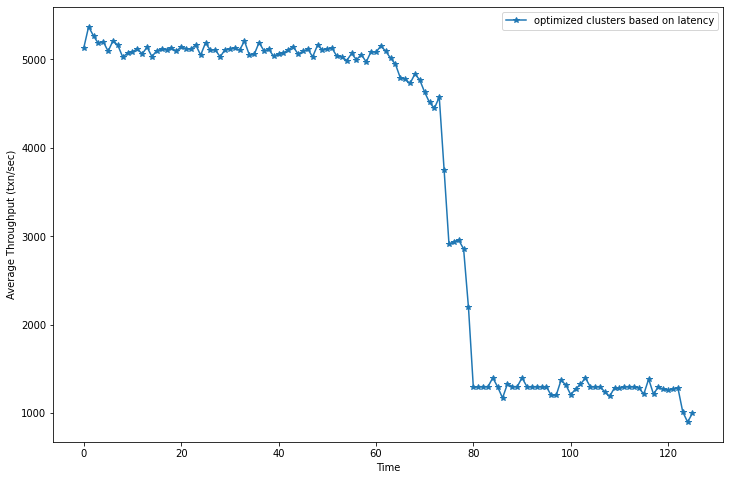

<Figure size 432x288 with 0 Axes>

In [153]:



fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')


pl.legend()
pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
# pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# pl.ylim(0,50)
# pl.savefig('/home/tejas/Desktop/OptClusters.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

In [154]:
# pl.figure(figsize = (12,8))
# pl.rcParams.update({'font.size': 17})
# fig.patch.set_facecolor('white')
# pl.plot(s1,s2, '-*', label = 'Hotstuff-MC: Leader Failure')


# pl.legend()
# pl.xlabel('Time')
# pl.ylabel('Throughput (txn/sec)')
# # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# # pl.ylim(0,50)
# pl.savefig('/home/tejas/Desktop/LeaderFailure_HotStuffMC.png', dpi =150, bbox_inches = 0 )
# pl.show()
# pl.clf()

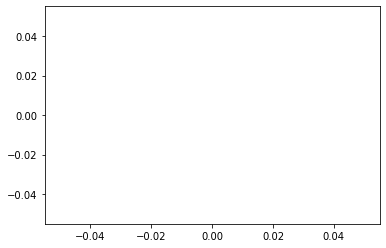

In [157]:
pl.plot(lats)
# pl.ylim(0,0.2)

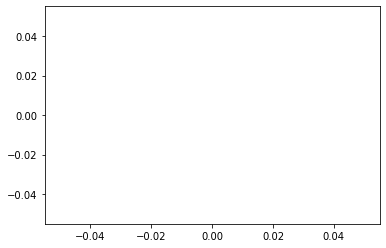

ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-111-215-70.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
0 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-65-2-151-32.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec0.conf >../nohup.out 2>&1 &"
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-232-39-192.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
6 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-111-168-212.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec6.conf >../nohup.out 2>&1 &"
1 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-85-179.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec1.conf >../nohup.out 2>&1 &"
ssh -o 

37 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-65-1-84-213.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec37.conf >../nohup.out 2>&1 &"
ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-43-205-115-215.ap-south-1.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx 1 --iter -1 --max-async 400 >../nohup.out 2>&1 &"
14 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-164-153.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec14.conf >../nohup.out 2>&1 &"
ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-232-193-119.ap-south-1.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx 3 --iter -1 --max-async 400 >../nohup.out 2>&1 &"
27 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Document

In [156]:
pl.plot(lats)
# pl.ylim(0,0.6)

In [60]:
lats

[]

In [61]:
os.system('grep -n -r "LatencyPlot: new node sending join request message" ../../../dump_files/')

256

In [62]:
os.system('grep -n -r "LatencyPlot: Received first message with new node info" ../../../dump_files/')

256

In [63]:
os.system('grep -n -r "LatencyPlot: Leader received with tentative sets from all peer nodes" ../../../dump_files/')        

256

In [64]:
1000*(32.776365 - 32.768622)

7.742999999997835

In [65]:
os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

256

In [66]:
os.system('grep -n -r "LatencyPlot: Received initial join message" ../../../dump_files/')        

256

In [67]:
os.system('grep -n -r "Sending Join Init message with height" ../../../dump_files/')        

256

In [68]:
1000*(17.534818-17.534437)

0.3810000000008529

In [69]:
os.system('grep -n -r "LatencyPlot: Sent response to  initial join message" ../../../dump_files/')        

256

In [70]:

    
os.system('grep -n -r "LatencyPlot: Received second join message" ../../../dump_files/')        

256

In [71]:
17.536482

17.536482

In [72]:
# os.system('grep -n -r "quorum reached for second join message with cluster_id" ../../../dump_files/')

In [73]:
# os.system('grep -n -r "LatencyPlot: Received 1st MC message" ../../../dump_files/')

In [74]:
# os.system('grep -n -r "LatencyPlot: before sending first mc message" ../../../dump_files/')

In [75]:
# 1000*(32.676090-32.612236)

In [76]:
# os.system('grep -n -r "LatencyPlot: going to execute based on 2nd MC message" ../../../dump_files/')


# os.system('grep -n -r "LatencyPlot: Finished execution" ../../../dump_files/')

# os.system('grep -n -r "LatencyPlot: Processing message from client" ../../../dump_files/')    

In [77]:
# os.system('grep -n -r "LatencyPlot: before initial join message" ../../../dump_files/')    

In [78]:
# # os.system('grep -n -r "LatencyPlot: " ../../../dump_files/')

# 1000*(11.479877-11.479442), 1000*(11.484887-11.479877),1000*(56.048590-56.046569), 1000*(56.050021 - 56.048590)

# # exec, # first mc, #second mc

# 1000*(56.050377 - 56.050181), 1000*(56.049389-56.049025), 1000*(56.050875-56.049389), 1000*(56.046557-56.038591) 


# # with open('opt1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('opt1.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)
  
    








# # with open('equiCluster1.npy', 'wb') as f:
# #     np.save(f, s1)
# #     np.save(f, s2)
    

    
# # with open('equiCluster1.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)
  
    
    
    
# # with open('equiCluster.npy', 'rb') as f:
# #     eq1 = np.load(f)
# #     eq2 = np.load(f)

    
# # with open('lat.npy', 'rb') as f:
# #     lat1 = np.load(f)
# #     lat2 = np.load(f)

    
    
# # with open('opt.npy', 'rb') as f:
# #     opt1 = np.load(f)
# #     opt2 = np.load(f)


# fig = pl.figure(figsize = (12, 8))
# fig.patch.set_facecolor('white')
# pl.plot(s1,s2, '-*', label = 'optimized clusters based on latency')

# # pl.plot(eq1,eq2, '-*', label = 'optimized clusters: equal clusters (7 (R1),7 (R2)')
# # pl.plot(lat1,lat2, '-*', label = 'optimized clusters: latency (9 (R1),5 (R2))')
# # pl.plot(opt1,opt2, '-*', label = 'optimized clusters: latency and heterogeneity (4 (R1),5 (R1), 5 (R2))')
# pl.legend()
# pl.xlabel('Time')
# pl.ylabel('Average Throughput (txn/sec)')
# # pl.title('HotStuff Multicluster: Throughput in Optimized Vs Non-Optimized Clusters')

# # pl.ylim(0,350)
# # pl.savefig('/home/tejas/Desktop/OptClusters.png', dpi =150, bbox_inches = 0 )
# pl.show()
# pl.clf()

0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-15-206-93-127.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-234-226-135.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
0
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-224-80.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
0
0
5 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-110-33-61.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec5.conf >../nohup.out 2>&1 &"
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-110-120-142.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
7 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-64-189.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo

0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-109-185-208.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
20 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-3-111-147-214.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec20.conf >../nohup.out 2>&1 &"
0
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-43-205-232-139.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
17 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-235-24-55.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec17.conf >../nohup.out 2>&1 &"
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-234-217-72.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
25 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem

0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-232-12-61.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
14 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-126-0-127.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec14.conf >../nohup.out 2>&1 &"
ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-15-206-93-127.ap-south-1.compute.amazonaws.com -T "cd hotstuffO; sudo nohup ./examples/hotstuff-client --idx 0 --iter -1 --max-async 400 >../nohup.out 2>&1 &"
0
0
ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-126-0-127.ap-south-1.compute.amazonaws.com -T "sudo rm -f nohup.out;"
32 ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem ubuntu@ec2-13-233-141-45.ap-south-1.compute.amazonaws.com  -T "cd hotstuffO; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec32.conf >../nohup.out

## Single Non-Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hs; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hs; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Single Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/NodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave

## Multiple Non Leader Failure

experiment = 'test'
os.system('rm hotstuff.gen*')
os.system('sh job_mini.sh '+ experiment)

os.system('cp hotstuff.gen* ../../')

os.system('cd ../../; git add .; git commit -m "testing rvc on server"; git push -f')

    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(setup_remote2)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(compile_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(clean_nodes_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results) 

def run_server_node_remote(i):
    ip = node_info_dict['publicIP'][i] 
#     if ip!='None' and( ip in nodeIps[:-3]):

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==0:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com  -T "cd hs; sudo nohup ./examples/hotstuff-app --conf hotstuff.gen-sec'+str(node_info_dict['ServerID'][i])+'.conf >../nohup.out 2>&1 &"'
        
        print(i,command)
        os.system(command)
        
        
    
for i in node_info_dict['publicIP']:
    run_server_node_remote(i)
    
    
time.sleep(20)



def run_client_node_remote(i):
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com -T "cd hs; sudo nohup ./examples/hotstuff-client --idx '+str(node_info_dict['clientID'][i])+' --iter -1 --max-async 40 >../nohup.out 2>&1 &"'
        
        print(command)
        os.system(command)




    
results = Parallel(n_jobs=len(list(node_info_dict['node_id'].keys())))(delayed(run_client_node_remote)(i)\
                                                                       for i in node_info_dict['node_id'])


print(results)  

    
# for i in node_info_dict['publicIP']:
#     run_client_node_remote(i)

time.sleep(40)

for i in node_info_dict['publicIP']:
    if i==3:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==7:
        print(i)
        kill_nodes_remote(i)
        
time.sleep(20)

for i in node_info_dict['publicIP']:
    if i==11:
        print(i)
        kill_nodes_remote(i)

time.sleep(45)

for i in node_info_dict['publicIP']:
    kill_nodes_remote(i)


for i in node_info_dict['publicIP']:
    ip = node_info_dict['publicIP'][i] 

    if ip!='None' and node_info_dict['ServerOrClientregion'][i]==1:
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/'+node_info_dict['key_file'][i].strip()[1:-1]+' '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.'+node_info_dict['region'][i].strip()[1:-1]+'.compute.amazonaws.com:/home/ubuntu/nohup.out ../../../dump_files/nohup_client_'+str(node_info_dict['clientID'][i])+'.out'
        print(command)
        os.system(command)

experiment = '../../dump_files'
X,Y, lats = getThroughput(experiment)
print(np.sum(Y)/len(Y), np.average(lats))

fig = pl.figure(figsize = (12, 8))
fig.patch.set_facecolor('white')
pl.plot(X[:-2],Y[:-2], '-*')
pl.axvline(x=40, ls='--', color = 'red')
pl.axvline(x=60, ls='--', color = 'green')
pl.axvline(x=80, ls='--', color = 'blue')

pl.xlabel('Time')
pl.ylabel('Average Throughput (txn/sec)')
pl.title('HotStuff Multicluster: Multiple Non-Leader Failure')

# pl.ylim(0,1000)
pl.savefig('/home/tejas/Desktop/MultiNodeFailure.png', dpi =150, bbox_inches = 0 )
pl.show()
pl.clf()

## Single Leave